# InPost - parcel volume forecasting

## Dataset overview

The data contains 4 datasets with different data between January 2021 and Sep 2023:

- dimDates.csv - data with the information of the days (year, month, day of the week, isHoliday, etc.)
- Posting_volumes.parquet - data with parcel volumes from Jan 2021 to Sep 2023
- X_ClientORDERS.xlsx - X client predictions for its parcel volume from Jan 2023
- Folder Temp - data with temperatures for each month 

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential #type: ignore
from keras.layers import LSTM, Dense, Dropout, InputLayer #type: ignore
from keras.optimizers import Adam #type: ignore
import tensorflow as tf
import random


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## dimDates.csv - Data preprocessing

In [209]:
df1 = pd.read_csv("data/dimDates.csv", sep = ";")
df1

,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,...,courierBillingPeriodStartDateFk,courierBillingPeriodEndDateFk,xlsDate,dwhDateFrom,dwhDateTo,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,20201004,2020-10-04,2020,2020,10.2020,T40-2020,Q4-2020,10,4,th,...,20201001,20201015,44108,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,20200810,2020-08-10,2020,2020,8.2020,T33-2020,Q3-2020,8,10,th,...,20200801,20200815,44053,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,20200930,2020-09-30,2020,2020,9.2020,T40-2020,Q3-2020,9,30,th,...,20200916,20200930,44104,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,20200521,2020-05-21,2020,2020,5.2020,T21-2020,Q2-2020,5,21,st,...,20200516,20200531,43972,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,20200527,2020-05-27,2020,2020,5.2020,T22-2020,Q2-2020,5,27,th,...,20200516,20200531,43978,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20200305,2020-03-05,2020,2020,3.2020,T10-2020,Q1-2020,3,5,th,...,20200301,20200315,43895,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1457,20200417,2020-04-17,2020,2020,4.2020,T16-2020,Q2-2020,4,17,th,...,20200416,20200430,43938,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1458,20201104,2020-11-04,2020,2020,11.2020,T45-2020,Q4-2020,11,4,th,...,20201101,20201115,44139,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1459,20201116,2020-11-16,2020,2020,11.2020,T47-2020,Q4-2020,11,16,th,...,20201116,20201130,44151,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


In [210]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   datePk                                               1461 non-null   int64  
 1   dateId                                               1461 non-null   object 
 2   dateYear                                             1461 non-null   int64  
 3   dateYearISO                                          1461 non-null   int64  
 4   dateMonthYear                                        1461 non-null   float64
 5   dateWeekYearISO                                      1461 non-null   object 
 6   dateQuarterYear                                      1461 non-null   object 
 7   dateMonth                                            1461 non-null   int64  
 8   dateDay                                              1461 non-null  

In [211]:
df1.dateMonthYear.unique()

array([10.202 ,  8.202 ,  9.202 ,  5.202 ,  6.202 ,  2.2021, 11.202 ,
        5.2021,  8.2021,  3.2023,  4.2023,  8.2023,  9.2023, 10.2023,
       11.2023,  3.202 ,  2.2023,  5.2023,  1.202 , 12.2023,  9.2022,
       10.2022,  1.2022,  5.2022,  4.2022,  8.2022,  6.2023, 12.2022,
       11.2022,  7.2022,  9.2021, 10.2021,  7.2023, 12.202 ,  4.202 ,
       11.2021,  4.2021,  3.2022,  2.2022,  6.2021,  7.2021,  1.2023,
       12.2021,  2.202 ,  1.2021,  7.202 ,  6.2022,  3.2021])

In [212]:
df1.dateId = pd.to_datetime(df1.dateId)
df1 = df1[(df1.dateId >= "2021-01-01") & (df1.dateId <= "2023-08-31")]
df1 = df1.rename(columns = {"dateId": "date"})
df1 = df1.sort_values(by = "date").reset_index(drop = True)

In [213]:
print("NA:", df1.isna().sum().sum())
print("Duplicated:", df1.duplicated().sum())

NA: 0
Duplicated: 0


In [214]:
df1

,datePk,date,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,...,courierBillingPeriodStartDateFk,courierBillingPeriodEndDateFk,xlsDate,dwhDateFrom,dwhDateTo,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,20210101,2021-01-01,2021,2020,1.2021,T53-2020,Q1-2021,1,1,st,...,20210101,20210115,44197,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,20210102,2021-01-02,2021,2020,1.2021,T53-2020,Q1-2021,1,2,nd,...,20210101,20210115,44198,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,20210103,2021-01-03,2021,2020,1.2021,T53-2020,Q1-2021,1,3,rd,...,20210101,20210115,44199,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,20210104,2021-01-04,2021,2021,1.2021,T1-2021,Q1-2021,1,4,th,...,20210101,20210115,44200,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,20210105,2021-01-05,2021,2021,1.2021,T1-2021,Q1-2021,1,5,th,...,20210101,20210115,44201,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,20230827,2023-08-27,2023,2023,8.2023,T34-2023,Q3-2023,8,27,th,...,20230816,20230831,45165,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
969,20230828,2023-08-28,2023,2023,8.2023,T35-2023,Q3-2023,8,28,th,...,20230816,20230831,45166,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
970,20230829,2023-08-29,2023,2023,8.2023,T35-2023,Q3-2023,8,29,th,...,20230816,20230831,45167,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
971,20230830,2023-08-30,2023,2023,8.2023,T35-2023,Q3-2023,8,30,th,...,20230816,20230831,45168,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


In [215]:
zero_variance_cols = [col for col in df1.columns if df1[col].nunique() == 1]
zero_variance_cols

['dwhDateFrom',
 'dwhDateTo',
 'dwhCurrRec',
 'dwhAuditCd',
 'dwhAuditCp',
 'dwhAuditMd',
 'dwhAuditMp']

In [216]:
df1 = df1.drop(zero_variance_cols, axis=1)

In [217]:
df1.iloc[:10, 0:20]

,datePk,date,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,dateWeekDay,dateWeekDayName,dateWeekDayNameShort,dateWeekDayNameFirstLetter,dateDayOfYear,dateWeekOfMonth,dateWeekOfYear,dateWeekOfYearISO,dateMonthName,dateMonthNameShort
0,20210101,2021-01-01,2021,2020,1.2021,T53-2020,Q1-2021,1,1,st,6,Friday,FRI,F,1,1,1,53,January,JAN
1,20210102,2021-01-02,2021,2020,1.2021,T53-2020,Q1-2021,1,2,nd,7,Saturday,SAT,S,2,1,1,53,January,JAN
2,20210103,2021-01-03,2021,2020,1.2021,T53-2020,Q1-2021,1,3,rd,1,Sunday,SUN,S,3,2,2,53,January,JAN
3,20210104,2021-01-04,2021,2021,1.2021,T1-2021,Q1-2021,1,4,th,2,Monday,MON,M,4,2,2,1,January,JAN
4,20210105,2021-01-05,2021,2021,1.2021,T1-2021,Q1-2021,1,5,th,3,Tuesday,TUE,T,5,2,2,1,January,JAN
5,20210106,2021-01-06,2021,2021,1.2021,T1-2021,Q1-2021,1,6,th,4,Wednesday,WED,W,6,2,2,1,January,JAN
6,20210107,2021-01-07,2021,2021,1.2021,T1-2021,Q1-2021,1,7,th,5,Thursday,THU,T,7,2,2,1,January,JAN
7,20210108,2021-01-08,2021,2021,1.2021,T1-2021,Q1-2021,1,8,th,6,Friday,FRI,F,8,2,2,1,January,JAN
8,20210109,2021-01-09,2021,2021,1.2021,T1-2021,Q1-2021,1,9,th,7,Saturday,SAT,S,9,2,2,1,January,JAN
9,20210110,2021-01-10,2021,2021,1.2021,T1-2021,Q1-2021,1,10,th,1,Sunday,SUN,S,10,3,3,1,January,JAN


In [218]:
len(df1)-(df1.firstDayNoHolidayNoSaturdayAfter == df1.firstDayNoHolidayNoSaturdayAfterData).sum()

1

In [219]:
(df1[df1.firstDayNoHolidayNoSaturdayAfter != df1.firstDayNoHolidayNoSaturdayAfterData]).loc[:, 
                                    ["date", "firstDayNoHolidayNoSundayAfter", "firstDayNoHolidayNoSaturdayAfterData"]]

,date,firstDayNoHolidayNoSundayAfter,firstDayNoHolidayNoSaturdayAfterData
356,2021-12-23,20211227,20201227


In [220]:
df1 = df1.drop(["dateDaySuffix", "dateWeekDayName", "dateWeekDayNameShort", "dateWeekDayNameFirstLetter", 
                "dateMonthName", "dateMonthNameShort", "dateMonthNameFirstLetter", "dateQuarterYear", "dateMonthYear",
                "dateQuarterShort", "dateWeekDayNamePL", "dateMonthNamePL", "xlsDate", "datePk", "dateYearISO",
                "dateQuarterName", "dateWeekYearISO", "dateWeekDay", "dateWeekOfYear", "dateWeekOfYearISO",
                "firstDayNoHolidayNoSaturdayAfterData", "firstDayNoSaturdayNoHolidayOrSundayHolidayName", "courierBillingPeriodDateFk"], axis = 1)

In [221]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   date                                                 973 non-null    datetime64[ns]
 1   dateYear                                             973 non-null    int64         
 2   dateMonth                                            973 non-null    int64         
 3   dateDay                                              973 non-null    int64         
 4   dateDayOfYear                                        973 non-null    int64         
 5   dateWeekOfMonth                                      973 non-null    int64         
 6   dateQuarter                                          973 non-null    int64         
 7   dateIsWeekend                                        973 non-null    int64         
 8   

In [222]:
for col in df1.columns:
    print(col, df1[col].nunique())

date 973
dateYear 3
dateMonth 12
dateDay 31
dateDayOfYear 365
dateWeekOfMonth 6
dateQuarter 4
dateIsWeekend 2
dateIsHolidayInd 2
dateWeekDayStartsMonday 7
dateWeekOfYearStartsMonday 53
firstDayWorkBefore 674
firstDayWorkAfter 673
firstDayNoHolidayNoSaturdayAfter 801
firstDayNoHolidayNoSundayAfter 809
firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday 2
firstDayNoSaturdayNoHolidayOrSundayHoliday 813
isThuHolyday 2
isFriHolyday 2
isSatHolyday 2
isWeekendParcelServiceBreakInd 2
courierBillingPeriodStartDateFk 64
courierBillingPeriodEndDateFk 64


In [223]:
df1["isWeekendParcelServiceBreakInd"] = df1["isWeekendParcelServiceBreakInd"].astype(int)
df1["firstDayWorkBefore"] = pd.to_datetime(df1["firstDayWorkBefore"].astype(str), format='%Y%m%d')
df1["firstDayWorkAfter"] = pd.to_datetime(df1["firstDayWorkAfter"].astype(str), format='%Y%m%d')
df1["firstDayNoHolidayNoSaturdayAfter"] = pd.to_datetime(df1["firstDayNoHolidayNoSaturdayAfter"].astype(str), format='%Y%m%d')
df1["firstDayNoHolidayNoSundayAfter"] = pd.to_datetime(df1["firstDayNoHolidayNoSundayAfter"].astype(str), format='%Y%m%d')
df1["firstDayNoSaturdayNoHolidayOrSundayHoliday"] = pd.to_datetime(df1["firstDayNoSaturdayNoHolidayOrSundayHoliday"].astype(str), format='%Y%m%d')
df1["courierBillingPeriodStartDateFk"] = pd.to_datetime(df1["courierBillingPeriodStartDateFk"].astype(str), format='%Y%m%d')
df1["courierBillingPeriodEndDateFk"] = pd.to_datetime(df1["courierBillingPeriodEndDateFk"].astype(str), format='%Y%m%d')

In [224]:
datetime_extract = ["firstDayWorkBefore", "firstDayWorkAfter", "firstDayNoHolidayNoSaturdayAfter", "firstDayNoHolidayNoSundayAfter",
                    "firstDayNoSaturdayNoHolidayOrSundayHoliday", "courierBillingPeriodStartDateFk", "courierBillingPeriodEndDateFk"]
for col in datetime_extract:
    df1[col + "_year"] = df1[col].dt.year
    df1[col + "_month"] = df1[col].dt.month
    df1[col + "_day"] = df1[col].dt.day

df1 = df1.drop(datetime_extract, axis = 1)

In [225]:
df1.iloc[-10:, 0:20]

,date,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,dateWeekOfYearStartsMonday,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,firstDayWorkBefore_year,firstDayWorkBefore_month,firstDayWorkBefore_day,firstDayWorkAfter_year
963,2023-08-22,2023,8,22,234,4,3,0,0,2,35,0,0,0,0,0,2023,8,21,2023
964,2023-08-23,2023,8,23,235,4,3,0,0,3,35,0,0,0,0,0,2023,8,22,2023
965,2023-08-24,2023,8,24,236,4,3,0,0,4,35,0,0,0,0,0,2023,8,23,2023
966,2023-08-25,2023,8,25,237,4,3,0,0,5,35,0,0,0,0,0,2023,8,24,2023
967,2023-08-26,2023,8,26,238,4,3,1,0,6,35,0,0,0,0,0,2023,8,25,2023
968,2023-08-27,2023,8,27,239,5,3,1,0,7,35,0,0,0,0,0,2023,8,25,2023
969,2023-08-28,2023,8,28,240,5,3,0,0,1,36,0,0,0,0,0,2023,8,25,2023
970,2023-08-29,2023,8,29,241,5,3,0,0,2,36,0,0,0,0,0,2023,8,28,2023
971,2023-08-30,2023,8,30,242,5,3,0,0,3,36,0,0,0,0,0,2023,8,29,2023
972,2023-08-31,2023,8,31,243,5,3,0,0,4,36,0,0,0,0,0,2023,8,30,2023


In [226]:
df1.iloc[-10:, 20:]

,firstDayWorkAfter_month,firstDayWorkAfter_day,firstDayNoHolidayNoSaturdayAfter_year,firstDayNoHolidayNoSaturdayAfter_month,firstDayNoHolidayNoSaturdayAfter_day,firstDayNoHolidayNoSundayAfter_year,firstDayNoHolidayNoSundayAfter_month,firstDayNoHolidayNoSundayAfter_day,firstDayNoSaturdayNoHolidayOrSundayHoliday_year,firstDayNoSaturdayNoHolidayOrSundayHoliday_month,firstDayNoSaturdayNoHolidayOrSundayHoliday_day,courierBillingPeriodStartDateFk_year,courierBillingPeriodStartDateFk_month,courierBillingPeriodStartDateFk_day,courierBillingPeriodEndDateFk_year,courierBillingPeriodEndDateFk_month,courierBillingPeriodEndDateFk_day
963,8,23,2023,8,23,2023,8,23,2023,8,23,2023,8,16,2023,8,31
964,8,24,2023,8,24,2023,8,24,2023,8,24,2023,8,16,2023,8,31
965,8,25,2023,8,25,2023,8,25,2023,8,25,2023,8,16,2023,8,31
966,8,28,2023,8,27,2023,8,26,2023,8,27,2023,8,16,2023,8,31
967,8,28,2023,8,27,2023,8,28,2023,8,27,2023,8,16,2023,8,31
968,8,28,2023,8,28,2023,8,28,2023,8,28,2023,8,16,2023,8,31
969,8,29,2023,8,29,2023,8,29,2023,8,29,2023,8,16,2023,8,31
970,8,30,2023,8,30,2023,8,30,2023,8,30,2023,8,16,2023,8,31
971,8,31,2023,8,31,2023,8,31,2023,8,31,2023,8,16,2023,8,31
972,9,1,2023,9,1,2023,9,1,2023,9,1,2023,8,16,2023,8,31


In [227]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 37 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   date                                                 973 non-null    datetime64[ns]
 1   dateYear                                             973 non-null    int64         
 2   dateMonth                                            973 non-null    int64         
 3   dateDay                                              973 non-null    int64         
 4   dateDayOfYear                                        973 non-null    int64         
 5   dateWeekOfMonth                                      973 non-null    int64         
 6   dateQuarter                                          973 non-null    int64         
 7   dateIsWeekend                                        973 non-null    int64         
 8   

## Posting_Volumes - Data preprocessing

In [228]:
df2 = pd.read_parquet("data/Posting_Volumes")
df2

,postingDateFk,Product,Customer,Volume
0,20210101,APM,X,2401.301452
1,20210102,APM,X,20195.515269
2,20210103,APM,X,63561.702640
3,20210104,APM,X,40310.645622
4,20210105,APM,X,54800.879137
...,...,...,...,...
3887,20230827,COURIER,Rest,388307.576620
3888,20230828,COURIER,Rest,234648.548766
3889,20230829,COURIER,Rest,333947.920499
3890,20230830,COURIER,Rest,324682.815539


In [229]:
df2["postingDateFk"] = pd.to_datetime(df2["postingDateFk"].astype(str), format='%Y%m%d')
df2 = df2.rename(columns = {"postingDateFk": "date"})
df2 = df2.sort_values(by = ["date", "Product", "Customer"]).reset_index(drop = True)

In [230]:
df2.head(10)

,date,Product,Customer,Volume
0,2021-01-01,APM,Rest,3124.683698
1,2021-01-01,APM,X,2401.301452
2,2021-01-01,COURIER,Rest,3849.234586
3,2021-01-01,COURIER,X,1992.428554
4,2021-01-02,APM,Rest,27224.314250
5,2021-01-02,APM,X,20195.515269
6,2021-01-02,COURIER,Rest,49570.405284
7,2021-01-02,COURIER,X,9477.377840
8,2021-01-03,APM,Rest,94206.975251
9,2021-01-03,APM,X,63561.702640


In [231]:
print("NA:", df2.isna().sum().sum())
print("Duplicated:", df2.duplicated().sum())

NA: 0
Duplicated: 0


In [232]:
df2.Volume.describe()

count      3892.000000
mean     143536.470533
std       87923.899208
min        -876.759667
25%       80150.606161
50%      130202.764469
75%      193735.702340
max      582617.649973
Name: Volume, dtype: float64

In [233]:
df2[df2.Volume < 0]

,date,Product,Customer,Volume
68,2021-01-18,APM,Rest,-565.057691
69,2021-01-18,APM,X,-501.072484
70,2021-01-18,COURIER,Rest,-876.759667
71,2021-01-18,COURIER,X,-421.967589


In [234]:
df2['Volume'] = df2['Volume'].where(df2['Volume'] >= 0, np.nan)
df2['Volume'] = df2['Volume'].interpolate(method='linear')
df2.Volume = df2.Volume.astype(int)

In [235]:
df2[(df2.date < "2021-01-20") & (df2.date > "2021-01-16")]

,date,Product,Customer,Volume
64,2021-01-17,APM,Rest,42346
65,2021-01-17,APM,X,33702
66,2021-01-17,COURIER,Rest,49207
67,2021-01-17,COURIER,X,23773
68,2021-01-18,APM,Rest,33553
69,2021-01-18,APM,X,43333
70,2021-01-18,COURIER,Rest,53113
71,2021-01-18,COURIER,X,62893
72,2021-01-19,APM,Rest,72673
73,2021-01-19,APM,X,50183


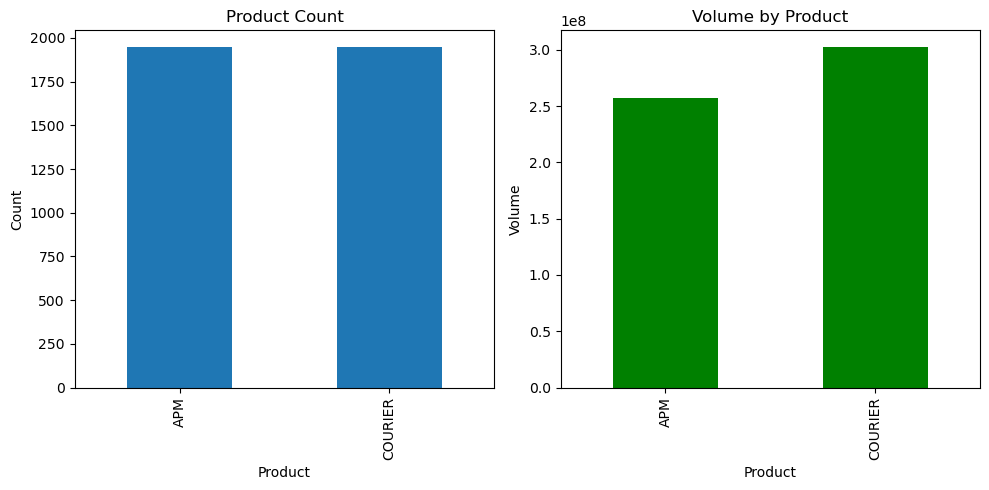

In [236]:
fig, sub = plt.subplots(1, 2, figsize=(10, 5))

df2.Product.value_counts().plot(kind='bar', ax = sub[0])
sub[0].set_title("Product Count")
sub[0].set_ylabel("Count")

df2.groupby("Product").Volume.sum().plot(kind='bar', ax = sub[1], color = "green")
sub[1].set_title("Volume by Product")
sub[1].set_ylabel("Volume")

plt.tight_layout()
plt.show()

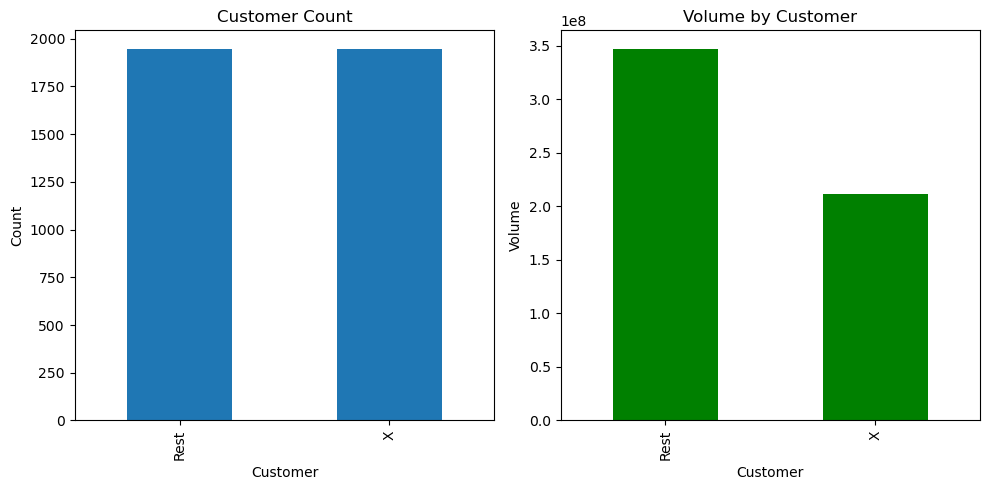

In [237]:
fig, sub = plt.subplots(1, 2, figsize=(10, 5))

df2.Customer.value_counts().plot(kind='bar', ax = sub[0])
sub[0].set_title("Customer Count")
sub[0].set_ylabel("Count")

df2.groupby("Customer").Volume.sum().plot(kind='bar', ax = sub[1], color = "green")
sub[1].set_title("Volume by Customer")
sub[1].set_ylabel("Volume")

plt.tight_layout()
plt.show()

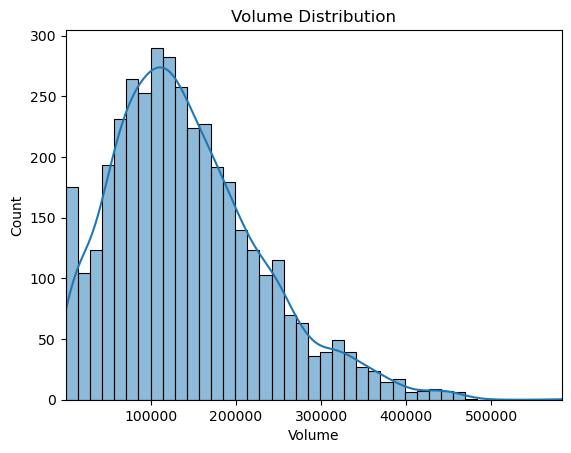

In [238]:
sns.histplot(df2.Volume, kde = True)
plt.xlim(df2.Volume.min(), df2.Volume.max())
plt.title('Volume Distribution')
plt.show()

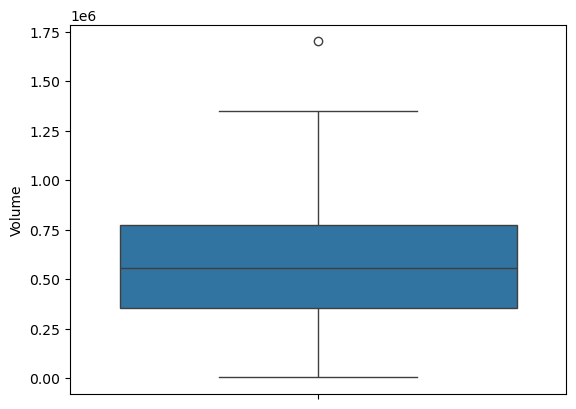

In [239]:
sns.boxplot(y = df2.Volume.groupby(df2.date).sum())
plt.show()

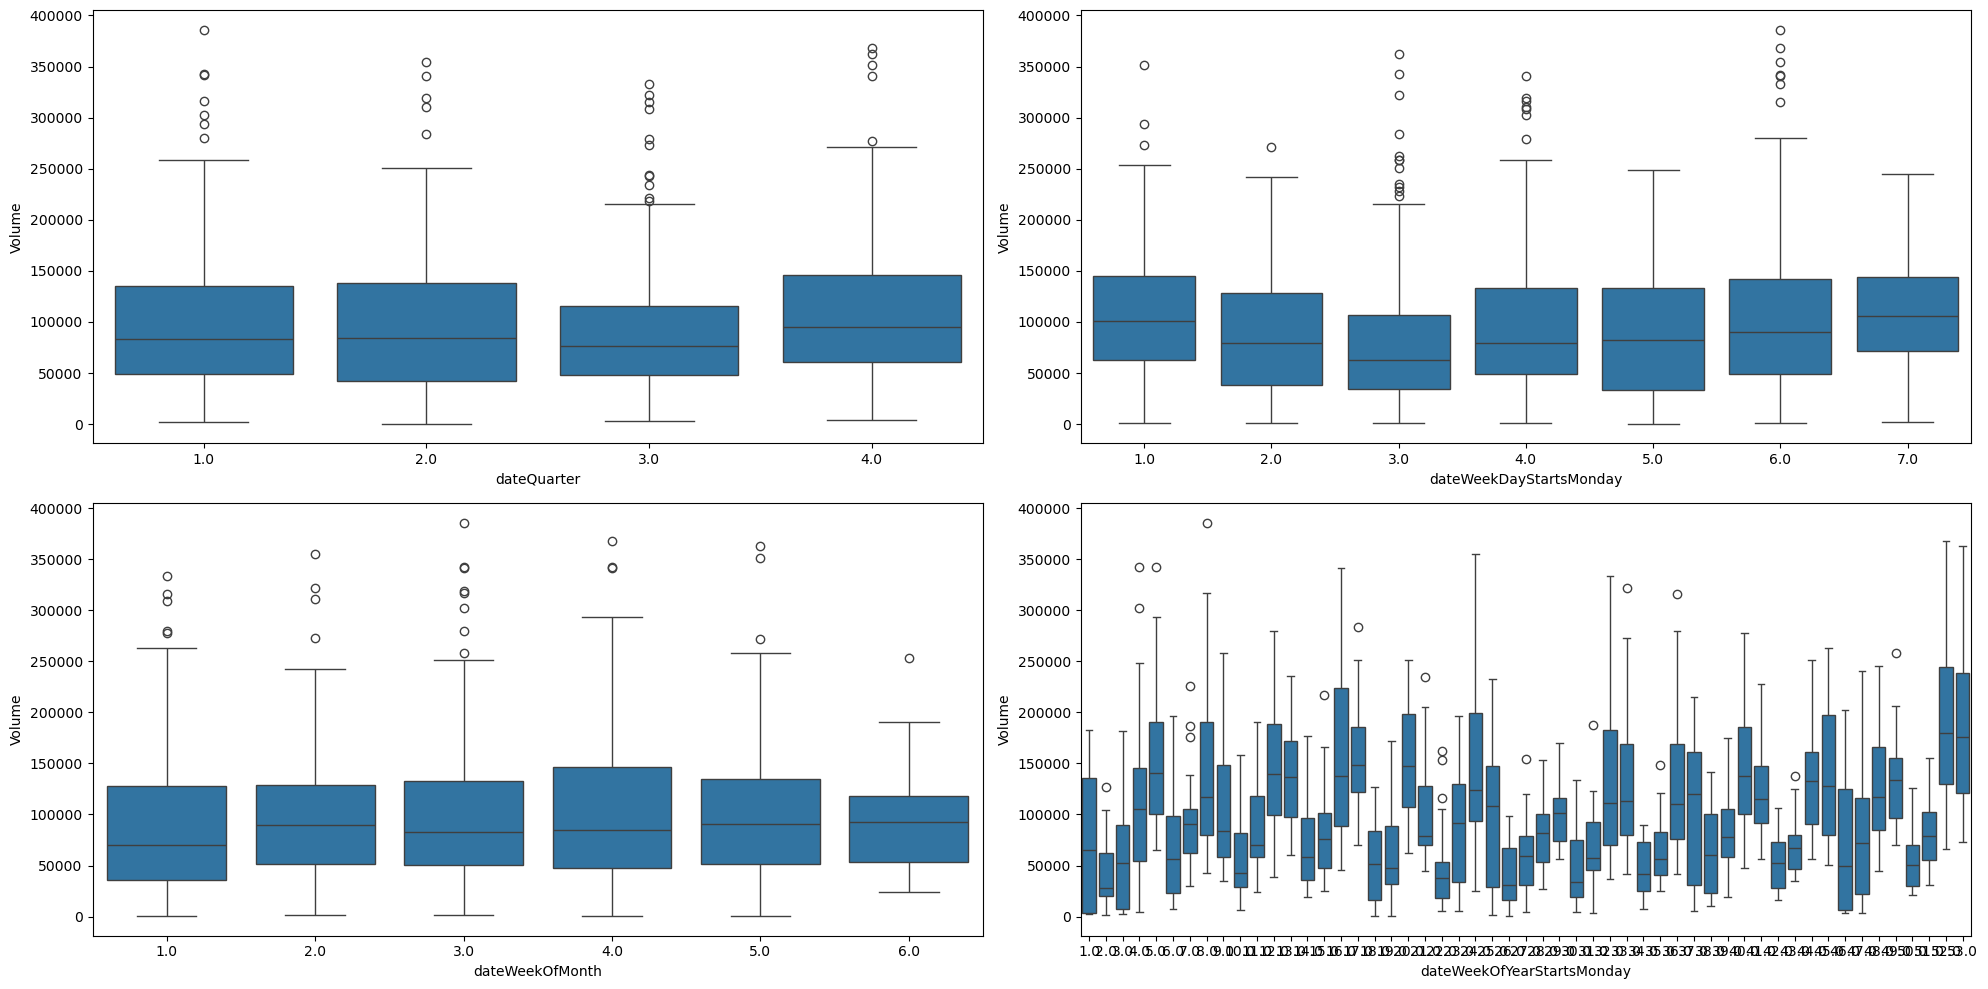

In [240]:
fig, sub = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(x = df1["dateQuarter"], y = df2["Volume"], ax = sub[0, 0])

sns.boxplot(x = df1["dateWeekDayStartsMonday"], y = df2["Volume"], ax = sub[0, 1])

sns.boxplot(x = df1["dateWeekOfMonth"], y = df2["Volume"], ax = sub[1, 0])

sns.boxplot(x = df1["dateWeekOfYearStartsMonday"], y = df2["Volume"], ax = sub[1, 1])

plt.tight_layout()
plt.show()

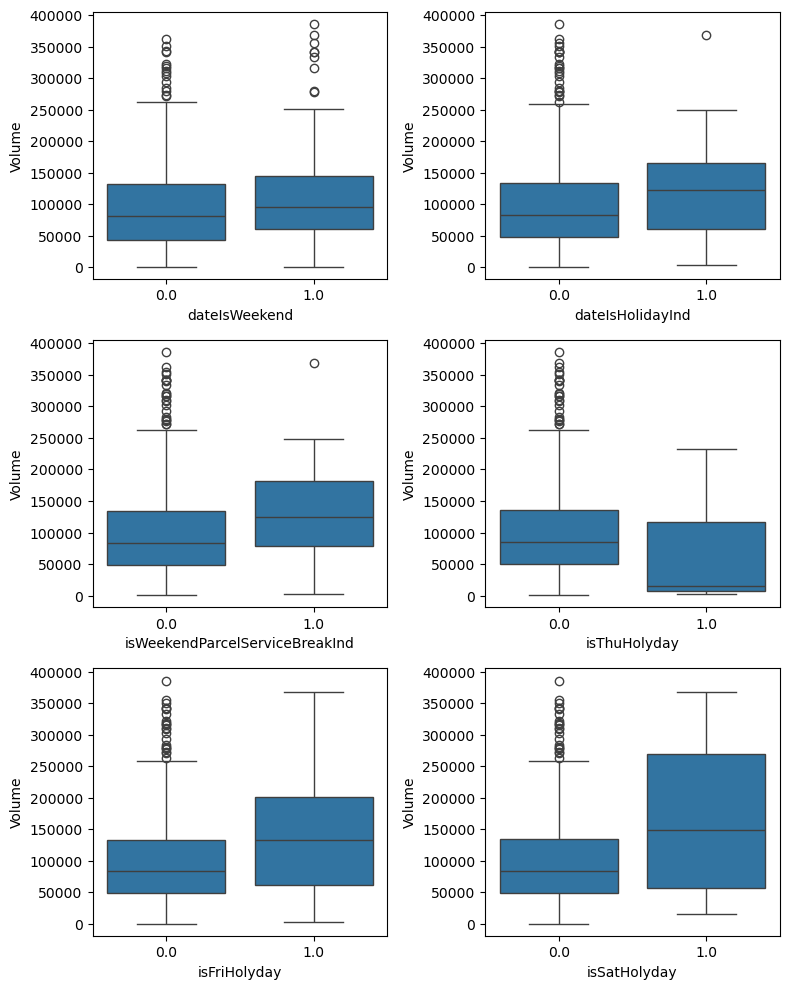

In [241]:
fig, sub = plt.subplots(3, 2, figsize=(8, 10))

sns.boxplot(x = df1["dateIsWeekend"], y = df2["Volume"], ax = sub[0, 0])

sns.boxplot(x = df1["dateIsHolidayInd"], y = df2["Volume"], ax = sub[0, 1])

sns.boxplot(x = df1["isWeekendParcelServiceBreakInd"], y = df2["Volume"], ax = sub[1, 0])

sns.boxplot(x = df1["isThuHolyday"], y = df2["Volume"], ax = sub[1, 1])

sns.boxplot(x = df1["isFriHolyday"], y = df2["Volume"], ax = sub[2, 0])

sns.boxplot(x = df1["isSatHolyday"], y = df2["Volume"], ax = sub[2, 1])

plt.tight_layout()
plt.show()

In [242]:
len(df2.Volume.groupby(df2.date).sum())

973

In [243]:
df2[df2.Volume > 500000]

,date,Product,Customer,Volume
3830,2023-08-16,COURIER,Rest,582617


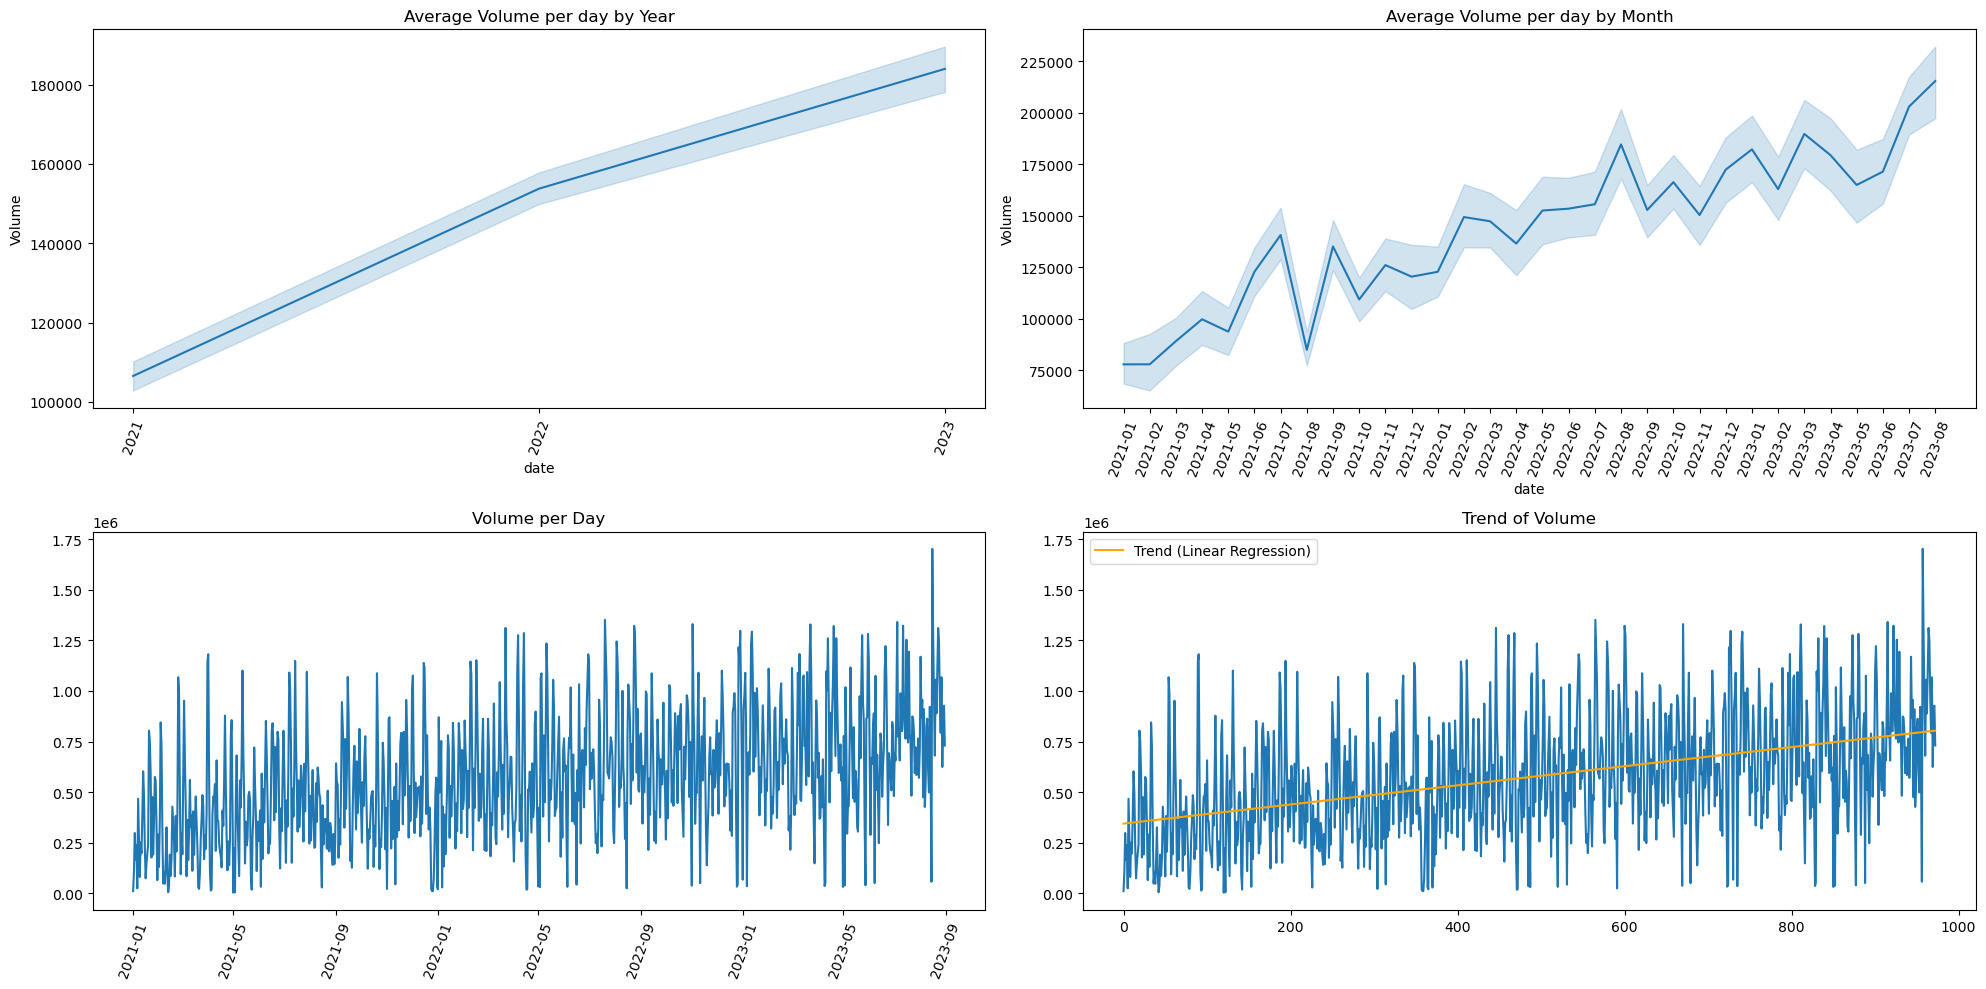

In [244]:
year = df2['date'].dt.to_period('Y').astype(str)
year_month = df2['date'].dt.to_period('M').astype(str)

fig, sub = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(ax=sub[0, 0], x=year, y=df2['Volume'])
sub[0, 0].set_title("Average Volume per day by Year")
sub[0, 0].tick_params(axis='x', rotation=70)

sns.lineplot(ax=sub[0, 1], x=year_month, y=df2['Volume'])
sub[0, 1].set_title("Average Volume per day by Month")
sub[0, 1].tick_params(axis='x', rotation=70)

sns.lineplot(ax=sub[1, 0],x=df2["date"].unique(), y=list(df2.groupby("date").Volume.sum()))
sub[1, 0].set_title("Volume per Day")
sub[1, 0].tick_params(axis='x', rotation=70)

time = np.arange(len(list(df2.groupby("date").Volume.sum()))) 
model = LinearRegression()
model.fit(time.reshape(-1, 1), list(df2.groupby("date").Volume.sum()))
trend = model.predict(time.reshape(-1, 1))

sns.lineplot(ax = sub[1, 1], x = time, y = list(df2.groupby("date").Volume.sum()))
sns.lineplot(ax = sub[1, 1], x = time, y = trend, label="Trend (Linear Regression)", color='orange')
sub[1, 1].set_title("Trend of Volume")

plt.tight_layout()
plt.show()

In [245]:
print("2023-08-15:", df2[df2["date"] == f"2023-08-15"].Volume.sum())
print("2023-08-16:", df2[df2["date"] == f"2023-08-16"].Volume.sum())

2023-08-15: 57688
2023-08-16: 1701724


In [246]:
df1[(df1["date"] == "2023-08-15") | (df1["date"] == "2023-08-16")][["date", "dateIsHolidayInd"]]

,date,dateIsHolidayInd
956,2023-08-15,1
957,2023-08-16,0


In [247]:
print("2022-11-11:", df2[df2["date"] == f"2022-11-11"].Volume.sum())
print("2022-11-12:", df2[df2["date"] == f"2022-11-12"].Volume.sum())

2022-11-11: 50544
2022-11-12: 649317


In [248]:
df1[(df1["date"] == "2022-11-11") | (df1["date"] == "2022-11-12")][["date", "dateIsHolidayInd"]]

,date,dateIsHolidayInd
679,2022-11-11,1
680,2022-11-12,0


In [249]:
df2.groupby("Product").Volume.describe()

,count,mean,std,min,25%,50%,75%,max
Product,,,,,,,,
APM,1946.0,131929.779034,76311.460198,722.0,75329.75,121797.0,177029.0,467654.0
COURIER,1946.0,155242.498458,96675.125030,575.0,84063.00,138615.0,211203.5,582617.0


In [250]:
df2_X = df2[df2["Customer"] == "X"].groupby("date").Volume.sum()
df2 = df2.groupby(["date"])["Volume"].sum().reset_index()

In [251]:
df2

,date,Volume
0,2021-01-01,11366
1,2021-01-02,106466
2,2021-01-03,298551
3,2021-01-04,167549
4,2021-01-05,237147
...,...,...
968,2023-08-27,1067478
969,2023-08-28,624374
970,2023-08-29,916677
971,2023-08-30,927150


## X_ClientORDERS - Data preprocessing

In [252]:
df3 = pd.read_excel("data/X_ClientORDERS.xlsx")
df3

,DateId,Orders
0,20230101,161366.064671
1,20230102,296627.324653
2,20230103,378262.368584
3,20230104,320907.583398
4,20230105,93098.214405
...,...,...
238,20230827,257302.285086
239,20230828,334471.057583
240,20230829,407334.926198
241,20230830,354357.441720


In [253]:
df3 = df3.drop(len(df3)-1, axis = 0)

In [254]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DateId  242 non-null    int64  
 1   Orders  242 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


In [255]:
df3.DateId = pd.to_datetime(df3.DateId, format='%Y%m%d')
df3 = df3.rename(columns = {"DateId": "date"})
df3.Orders = df3.Orders.astype(int)

In [256]:
df3

,date,Orders
0,2023-01-01,161366
1,2023-01-02,296627
2,2023-01-03,378262
3,2023-01-04,320907
4,2023-01-05,93098
...,...,...
237,2023-08-26,285916
238,2023-08-27,257302
239,2023-08-28,334471
240,2023-08-29,407334


In [257]:
df3.Orders.describe()

count       242.000000
mean     275093.876033
std       70057.787884
min       72473.000000
25%      224505.250000
50%      273695.500000
75%      325643.750000
max      416068.000000
Name: Orders, dtype: float64

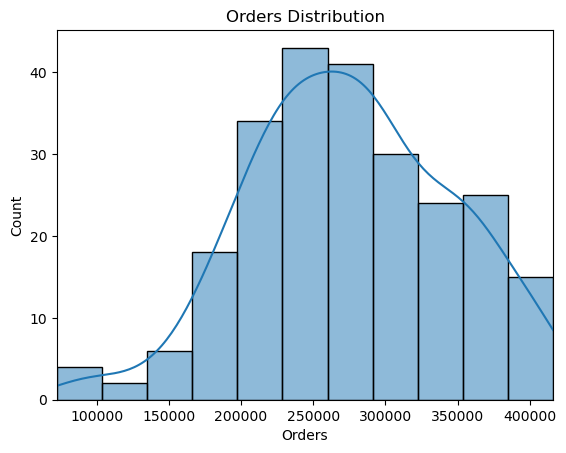

In [258]:
sns.histplot(df3.Orders, kde = True)
plt.xlim(df3.Orders.min(), df3.Orders.max())
plt.title('Orders Distribution')
plt.show()

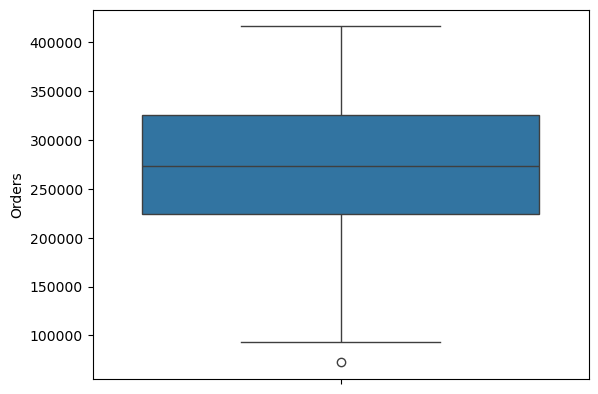

In [259]:
sns.boxplot(y = df3.Orders)
plt.show()

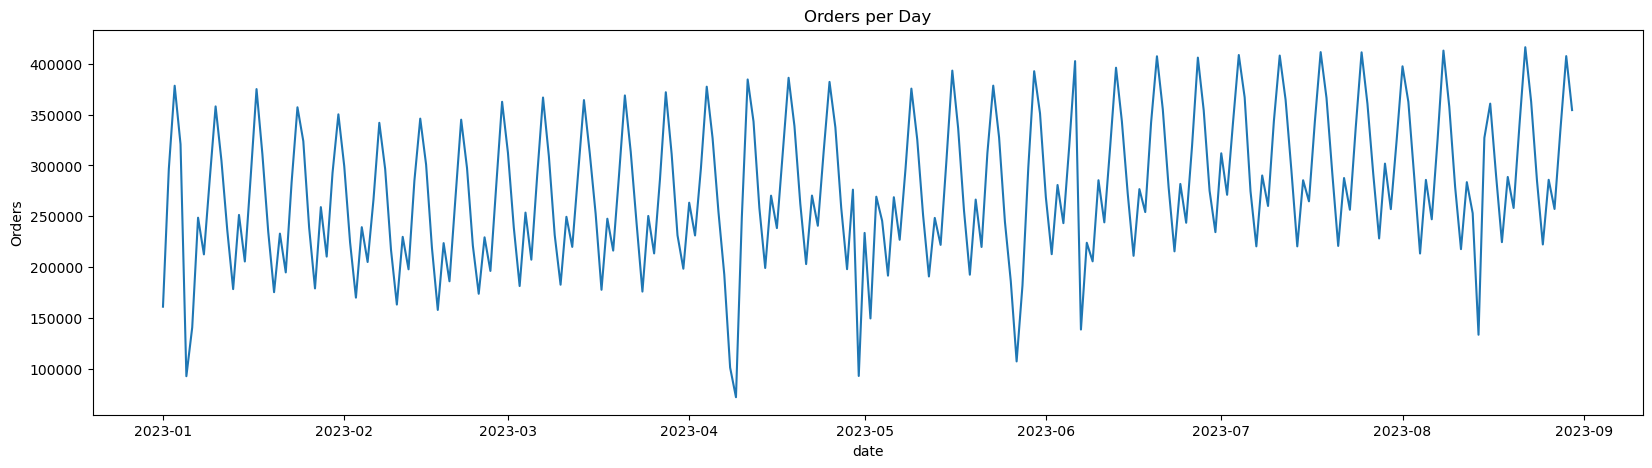

In [260]:
plt.figure(figsize=(20, 5))

sns.lineplot(x=df3.date, y=df3.Orders)
plt.title("Orders per Day")
plt.show()

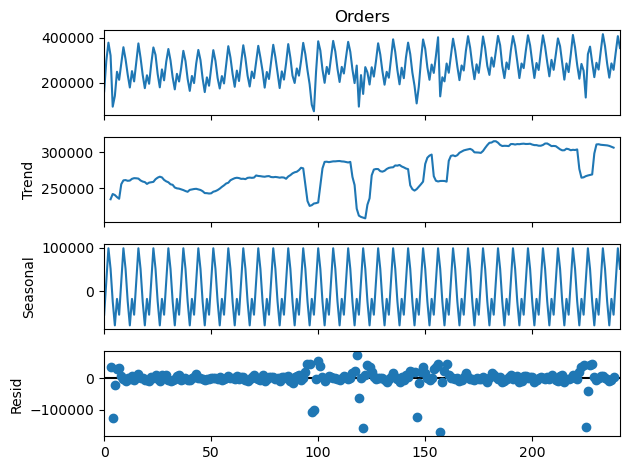

In [261]:
result = seasonal_decompose(df3['Orders'], model='additive', period=7)
result.plot()
plt.show()

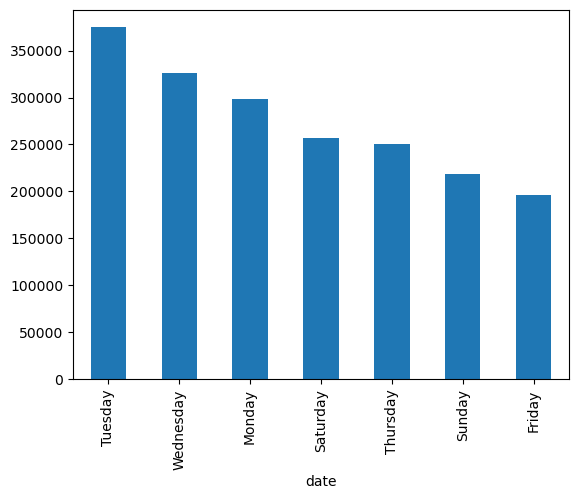

In [262]:
week_day = df3['date'].dt.day_name()
df3.groupby(week_day)['Orders'].mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

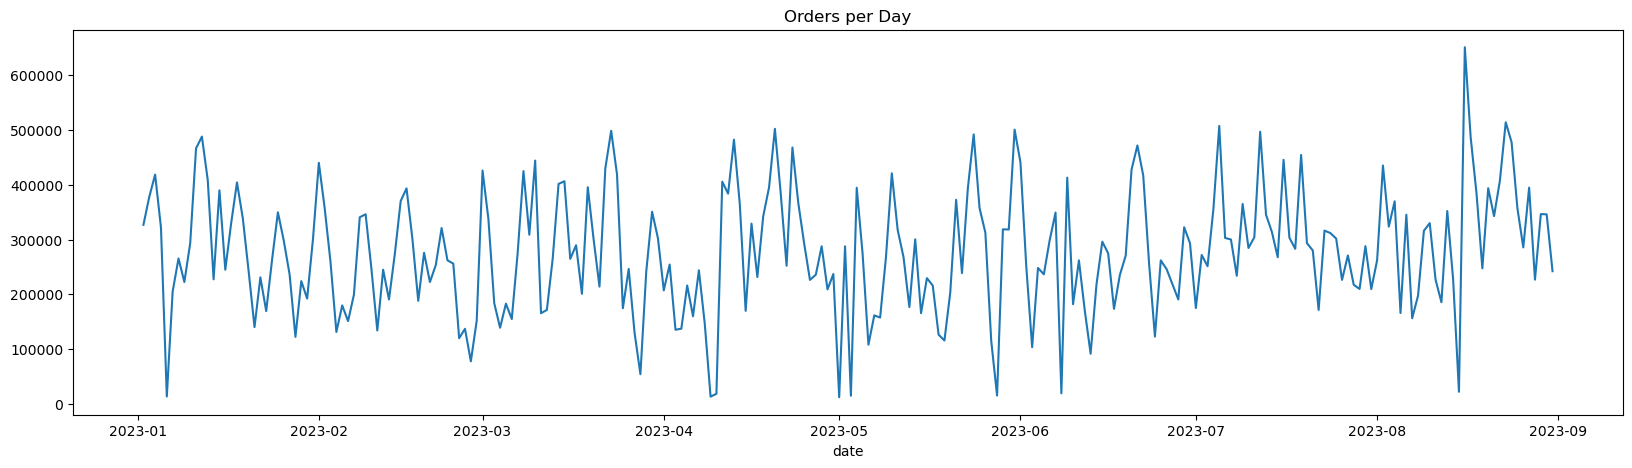

In [263]:
plt.figure(figsize=(20, 5))

sns.lineplot(x=df2_X[df2_X.index > "2023-01-01"].index, y=df2_X[df2_X.index > "2023-01-01"].values)
plt.title("Orders per Day")
plt.show()

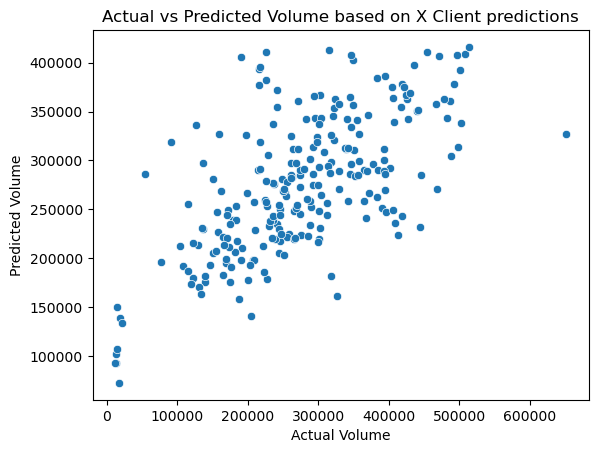

In [264]:
actual = list(df2_X[df2_X.index > "2023-01-01"].values)
predicted = df3.Orders

sns.scatterplot(x = actual, y = predicted)
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Actual vs Predicted Volume based on X Client predictions")
plt.show()

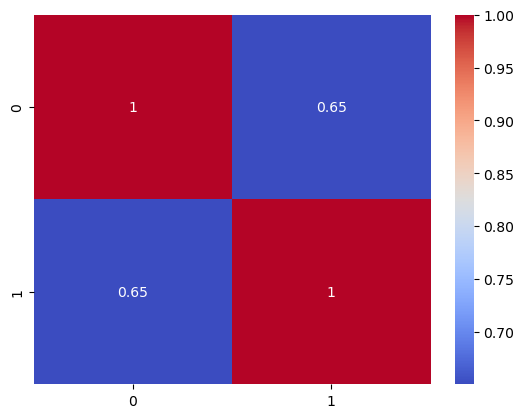

In [265]:
sns.heatmap(np.corrcoef(actual, predicted), annot = True, cmap = "coolwarm")
plt.show()

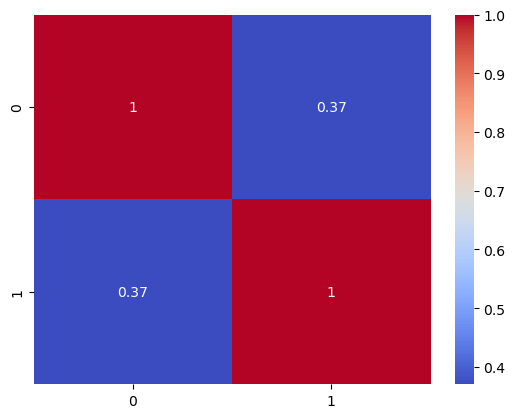

In [266]:
predicted_modified = [0] * len(df2_X[df2_X.index < "2023-01-02"].values) + df3.Orders.tolist()

sns.heatmap(np.corrcoef(df2_X.values, predicted_modified), annot = True, cmap = "coolwarm")
plt.show()

In [267]:
df3.date = df3.date + pd.Timedelta(days=1)
full_date_range = pd.date_range(start="2021-01-01", end=df3['date'].max())

full_df = pd.DataFrame({"date": full_date_range})
full_df['Orders'] = 0

result = pd.merge(full_df, df3, on="date", how="left")
result['Orders'] = result['Orders_y'].fillna(result['Orders_x']).astype(int)
result.loc[:, "forecast_available"] = [0 if x == 0 else 1 for x in result['Orders']]

df3 = result[['date', 'Orders', "forecast_available"]]
df3

,date,Orders,forecast_available
0,2021-01-01,0,0
1,2021-01-02,0,0
2,2021-01-03,0,0
3,2021-01-04,0,0
4,2021-01-05,0,0
...,...,...,...
968,2023-08-27,285916,1
969,2023-08-28,257302,1
970,2023-08-29,334471,1
971,2023-08-30,407334,1


## Temperatures - Data preprocessing

In [268]:
csv_files = [file for file in os.listdir("data/Temp") if file.endswith('.csv')]
dataframes = []

for file in csv_files:
    file_path = os.path.join("data/Temp", file)
    dataframes.append(pd.read_csv(file_path))

df4 = pd.concat(dataframes, ignore_index=True)

df4

,Nazwa stacji,Rok,Miesiac,Dzien,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,KRAKOW,2021,8,1,23.9,17.3,20.1,5.7,0
1,KRAKOW,2021,8,2,22.8,14.4,17.2,0.5,0
2,KRAKOW,2021,8,3,25.6,11.6,18.3,0.4,0
3,KRAKOW,2021,8,4,24.9,14.3,19.4,5.2,0
4,KRAKOW,2021,8,5,21.5,15.9,17.5,103.4,0
...,...,...,...,...,...,...,...,...,...
1941,WARSZAWA,2022,11,26,1.1,0.1,0.6,0.0,0
1942,WARSZAWA,2022,11,27,3.3,0.1,1.7,0.0,0
1943,WARSZAWA,2022,11,28,2.7,0.6,1.3,0.0,0
1944,WARSZAWA,2022,11,29,1.3,0.1,0.7,0.0,0


In [269]:

df4 = df4.rename(columns = {"Nazwa stacji": "city",
                            "Rok": "year",
                            "Miesiac": "month",
                            "Dzien": "day",
                            "Maksymalna temperatura dobowa": "temp_max", 
                            "Minimalna temperatura dobowa": "temp_min",
                            "Srednia temperatura dobowa": "temp_avg",
                            "Suma dobowa opadow [mm]": "total_rainfall",
                            "Pokrywa sniegu [cm]": "snow_cover",
                            })

df4['date'] = pd.to_datetime(df4[['year', 'month', 'day']])
df4 = df4.drop(["year", "month", "day"], axis = 1)
df4 = df4.sort_values(by = "date").reset_index(drop = True)

In [270]:
df4 = df4[["date", "city", "temp_max", "temp_min", "temp_avg", "total_rainfall", "snow_cover"]]
df4.head()

,date,city,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
0,2021-01-01,KRAKOW,0.5,-1.2,-0.5,0.0,0
1,2021-01-01,WARSZAWA,0.9,-1.2,-0.2,0.0,0
2,2021-01-02,WARSZAWA,1.2,-0.9,0.3,0.0,0
3,2021-01-02,KRAKOW,4.4,-1.6,0.8,0.0,0
4,2021-01-03,WARSZAWA,2.4,0.8,1.2,0.0,0


In [271]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1946 non-null   datetime64[ns]
 1   city            1946 non-null   object        
 2   temp_max        1946 non-null   float64       
 3   temp_min        1946 non-null   float64       
 4   temp_avg        1946 non-null   float64       
 5   total_rainfall  1946 non-null   float64       
 6   snow_cover      1946 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 106.5+ KB


In [272]:
temp_max = df4.groupby("date").temp_max.max().values
temp_min = df4.groupby("date").temp_min.min().values
temp_avg = df4.groupby("date").temp_avg.mean().values
total_rainfall = df4.groupby("date").total_rainfall.sum().values
snow_cover = df4.groupby("date").snow_cover.max().values

df4 = pd.DataFrame({"date": df4.date.unique(), 
                    "temp_max": temp_max, 
                    "temp_min": temp_min, 
                    "temp_avg": temp_avg, 
                    "total_rainfall": total_rainfall, 
                    "snow_cover": snow_cover})

In [273]:
df4

,date,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
0,2021-01-01,0.9,-1.2,-0.35,0.0,0
1,2021-01-02,4.4,-1.6,0.55,0.0,0
2,2021-01-03,4.0,-0.9,1.15,0.0,0
3,2021-01-04,4.9,-0.7,1.95,7.1,0
4,2021-01-05,4.0,1.4,2.65,4.3,0
...,...,...,...,...,...,...
968,2023-08-27,28.6,17.7,22.20,0.5,0
969,2023-08-28,23.7,17.3,19.45,0.1,0
970,2023-08-29,26.1,17.5,21.05,0.9,0
971,2023-08-30,22.0,16.7,18.30,0.3,0


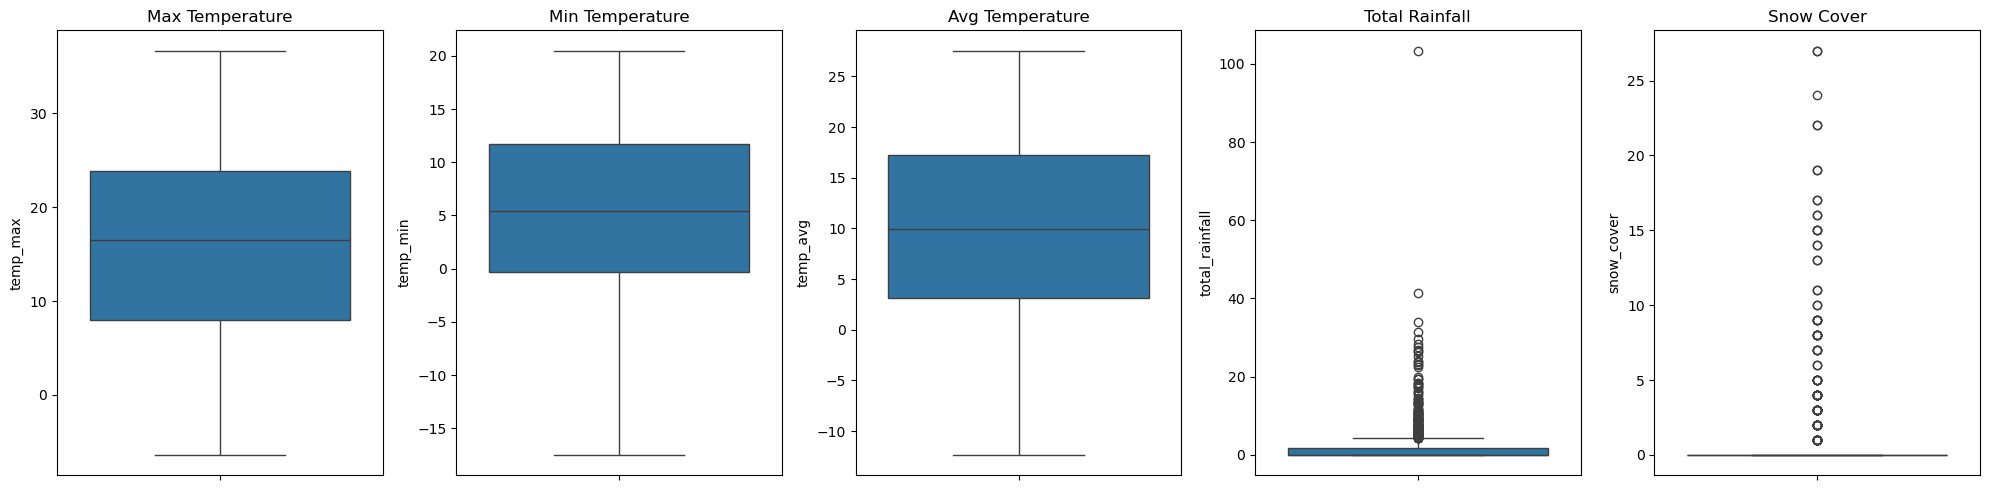

In [274]:
fig, sub = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(y = df4.temp_max, ax = sub[0])
sub[0].set_title("Max Temperature")

sns.boxplot(y = df4.temp_min, ax = sub[1])
sub[1].set_title("Min Temperature")

sns.boxplot(y = df4.temp_avg, ax = sub[2])
sub[2].set_title("Avg Temperature")


sns.boxplot(y = df4.total_rainfall, ax = sub[3])
sub[3].set_title("Total Rainfall")

sns.boxplot(y = df4.snow_cover, ax = sub[4])
sub[4].set_title("Snow Cover")

plt.tight_layout()
plt.show()


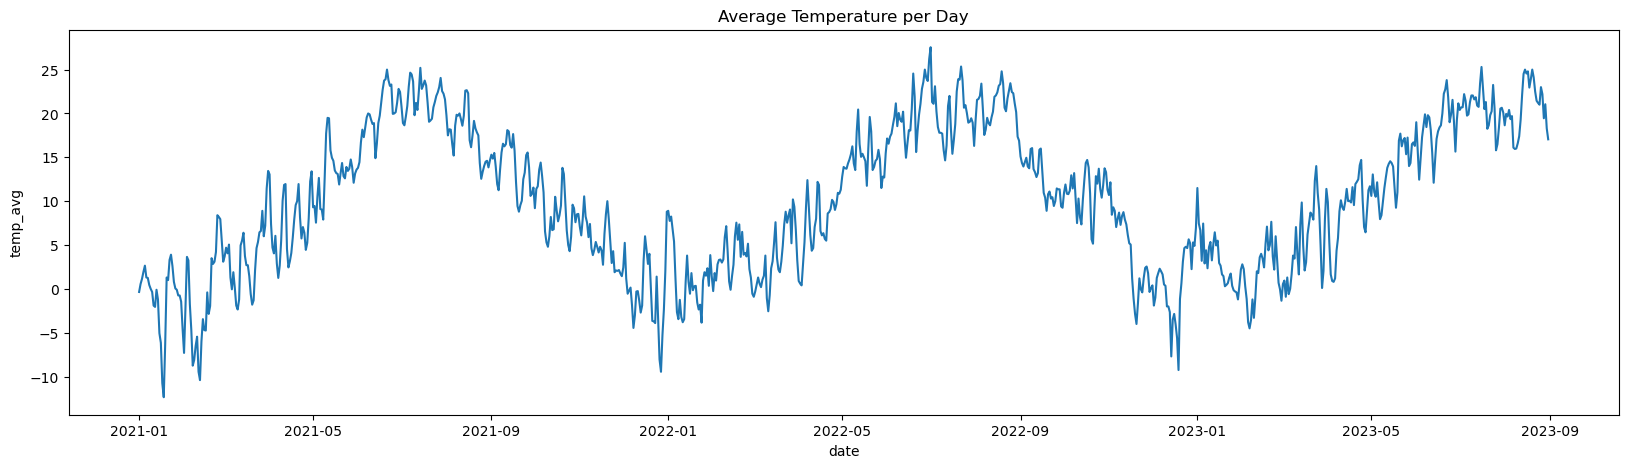

In [275]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=df4.date, y=df4.temp_avg)
plt.title("Average Temperature per Day")
plt.show()

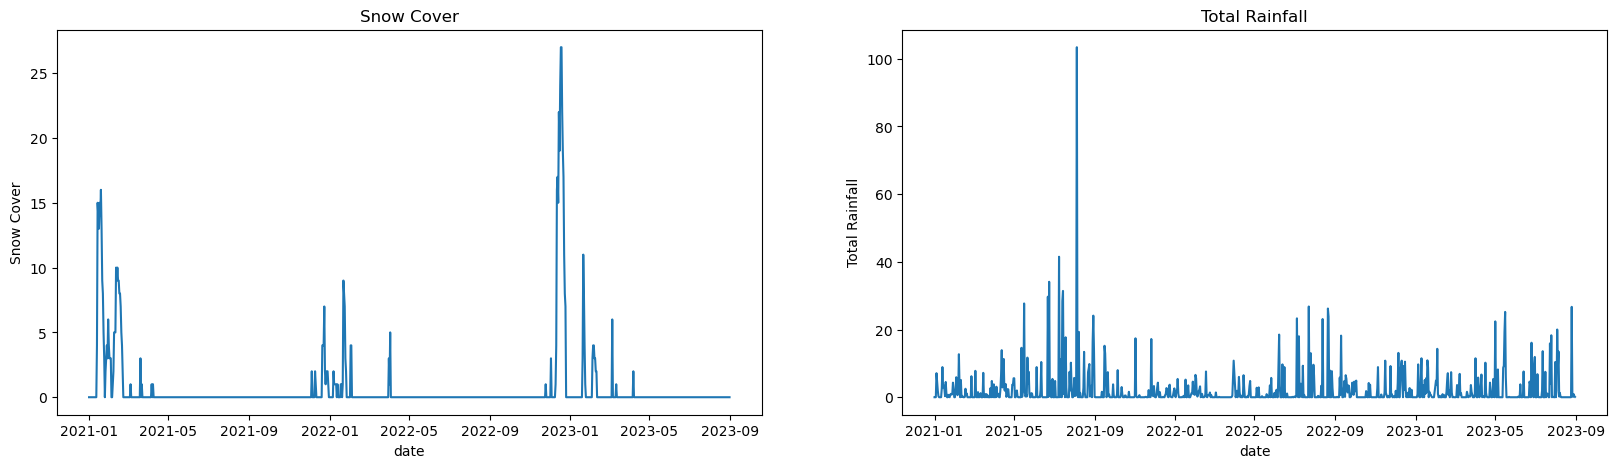

In [276]:
fig, sub = plt.subplots(1, 2, figsize=(20, 5))


sns.lineplot(x=df4.date, y=df4.snow_cover, ax = sub[0])
sub[0].set_title("Snow Cover")
sub[0].set_ylabel("Snow Cover")

sns.lineplot(x=df4.date, y=df4.total_rainfall)
sub[1].set_title("Total Rainfall")
sub[1].set_ylabel("Total Rainfall")

plt.show()

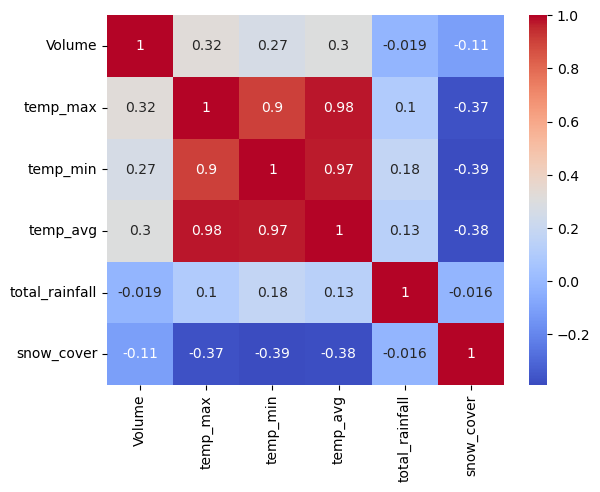

In [277]:
sns.heatmap(pd.concat([df2.Volume, df4.iloc[:, 1:]], axis = 1).corr(), annot = True, cmap = "coolwarm")
plt.show()

## Data merging

In [278]:
df = df2.merge(df1, left_on="date", right_on = "date", how="left")
df = df.merge(df3, left_on="date", right_on = "date", how="left")
df = df.merge(df4, left_on="date", right_on = "date", how="left")

df.to_csv("data/merged_data.csv", index=False)

df.index = df.date
df = df.drop("date", axis = 1)
df.sort_index(inplace=True)

In [279]:
df

,Volume,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,...,courierBillingPeriodEndDateFk_year,courierBillingPeriodEndDateFk_month,courierBillingPeriodEndDateFk_day,Orders,forecast_available,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,11366,2021,1,1,1,1,1,0,1,5,...,2021,1,15,0,0,0.9,-1.2,-0.35,0.0,0
2021-01-02,106466,2021,1,2,2,1,1,1,0,6,...,2021,1,15,0,0,4.4,-1.6,0.55,0.0,0
2021-01-03,298551,2021,1,3,3,2,1,1,0,7,...,2021,1,15,0,0,4.0,-0.9,1.15,0.0,0
2021-01-04,167549,2021,1,4,4,2,1,0,0,1,...,2021,1,15,0,0,4.9,-0.7,1.95,7.1,0
2021-01-05,237147,2021,1,5,5,2,1,0,0,2,...,2021,1,15,0,0,4.0,1.4,2.65,4.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,1067478,2023,8,27,239,5,3,1,0,7,...,2023,8,31,285916,1,28.6,17.7,22.20,0.5,0
2023-08-28,624374,2023,8,28,240,5,3,0,0,1,...,2023,8,31,257302,1,23.7,17.3,19.45,0.1,0
2023-08-29,916677,2023,8,29,241,5,3,0,0,2,...,2023,8,31,334471,1,26.1,17.5,21.05,0.9,0


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 973 entries, 2021-01-01 to 2023-08-31
Data columns (total 44 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Volume                                               973 non-null    int64  
 1   dateYear                                             973 non-null    int64  
 2   dateMonth                                            973 non-null    int64  
 3   dateDay                                              973 non-null    int64  
 4   dateDayOfYear                                        973 non-null    int64  
 5   dateWeekOfMonth                                      973 non-null    int64  
 6   dateQuarter                                          973 non-null    int64  
 7   dateIsWeekend                                        973 non-null    int64  
 8   dateIsHolidayInd                                   

In [281]:
IQR = df.Volume.quantile(0.75) - df.Volume.quantile(0.25)
lower_bound = df.Volume.quantile(0.25) - 1.5*IQR
upper_bound = df.Volume.quantile(0.75) + 1.5*IQR

df[(df.Volume <= lower_bound) | (df.Volume >= upper_bound)]

,Volume,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,...,courierBillingPeriodEndDateFk_year,courierBillingPeriodEndDateFk_month,courierBillingPeriodEndDateFk_day,Orders,forecast_available,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
date,,,,,,,,,,,,,,,,,,,,,
2023-08-16,1701724,2023,8,16,228,3,3,0,0,3,...,2023,8,31,327138,1,32.5,17.2,24.55,0.0,0


In [282]:
df.loc[df.Volume == 1701724, "Volume"] = np.nan
df = df.interpolate(method='linear')

## SARIMA model - univariate forecasting

In [283]:
df_arima = df.Volume

In [284]:
test_days = 90
train = df_arima[:-test_days]
test = df_arima[-test_days:]
len(train), len(test)

(883, 90)

In [285]:
result = adfuller(train)
print("p-value:", result[1])

p-value: 0.03058361066012888


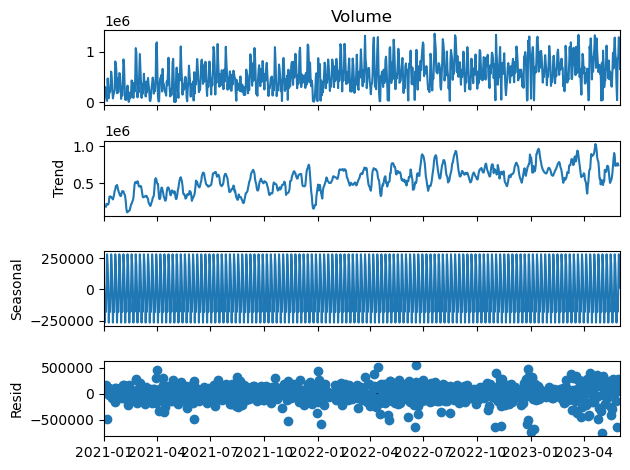

In [286]:
weekly_decompose = seasonal_decompose(train, model="additive", period=7)
weekly_decompose.plot()

plt.show()

In [287]:
lb_test = acorr_ljungbox(train, lags=[7, 30], return_df=True)
print(lb_test)

        lb_stat      lb_pvalue
7    595.354493  2.436985e-124
30  1760.929688   0.000000e+00


In [288]:
seasonal_diff = train.diff(periods=7).dropna()

result = adfuller(seasonal_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -9.642079453379694
p-value: 1.5114759741744367e-16


In [289]:
model_auto = auto_arima(train, seasonal=True, m=7)
print(f"Suggested ARIMA parameters: {model_auto.order}x{model_auto.seasonal_order}")

Suggested ARIMA parameters: (4, 1, 2)x(2, 0, 1, 7)


In [290]:
p, d, q = model_auto.order
P, D, Q, S = model_auto.seasonal_order
arima = ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
print(arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  883
Model:             ARIMA(4, 1, 2)x(2, 0, [1], 7)   Log Likelihood              -11985.116
Date:                           Wed, 18 Dec 2024   AIC                          23990.231
Time:                                   22:35:37   BIC                          24038.053
Sample:                               01-01-2021   HQIC                         24008.517
                                    - 06-02-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5022      0.036    -13.768      0.000      -0.574      -0.431
ar.L2          0.4773      0.046     10.384

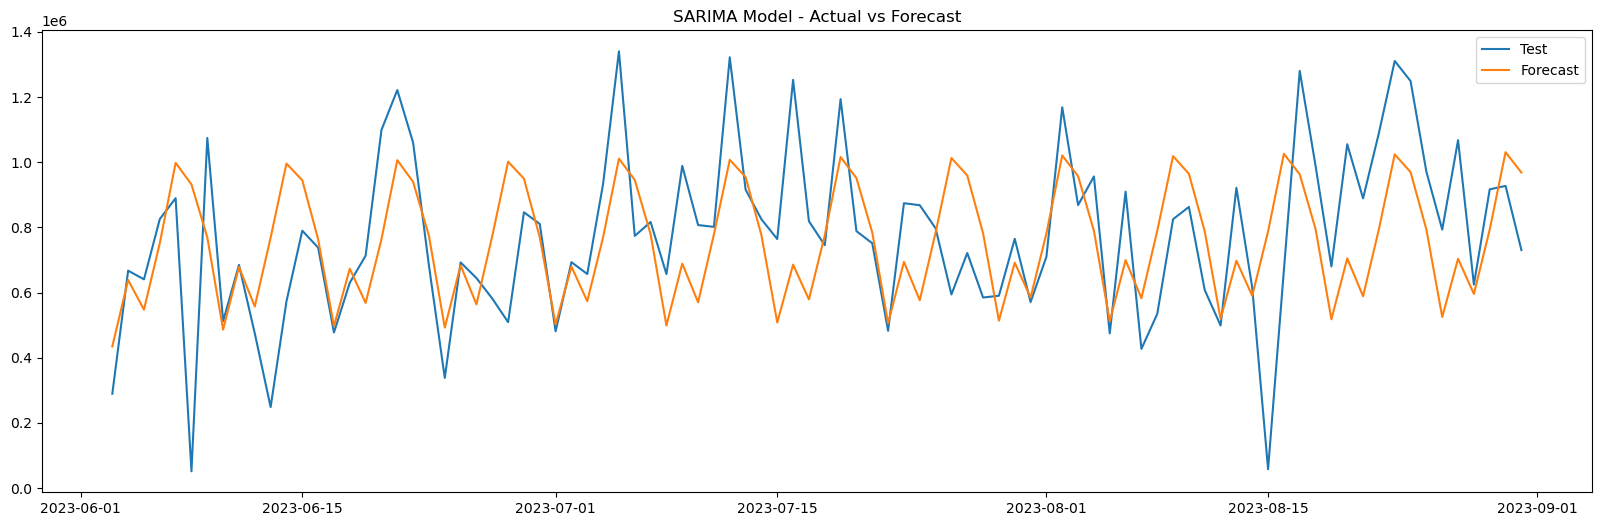

RMSE: 240646.7631
MAE: 181138.4720


In [291]:
forecast_steps = len(test)
forecast = arima.forecast(steps=forecast_steps)
forecast_index = test.index

test_values = test.values
rmse_sarima = np.sqrt(mean_squared_error(test_values, forecast))
mae_sarima = mean_absolute_error(test_values, forecast)

plt.figure(figsize=(20, 6))
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend(loc='best')
plt.title('SARIMA Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAE: {mae_sarima:.4f}")

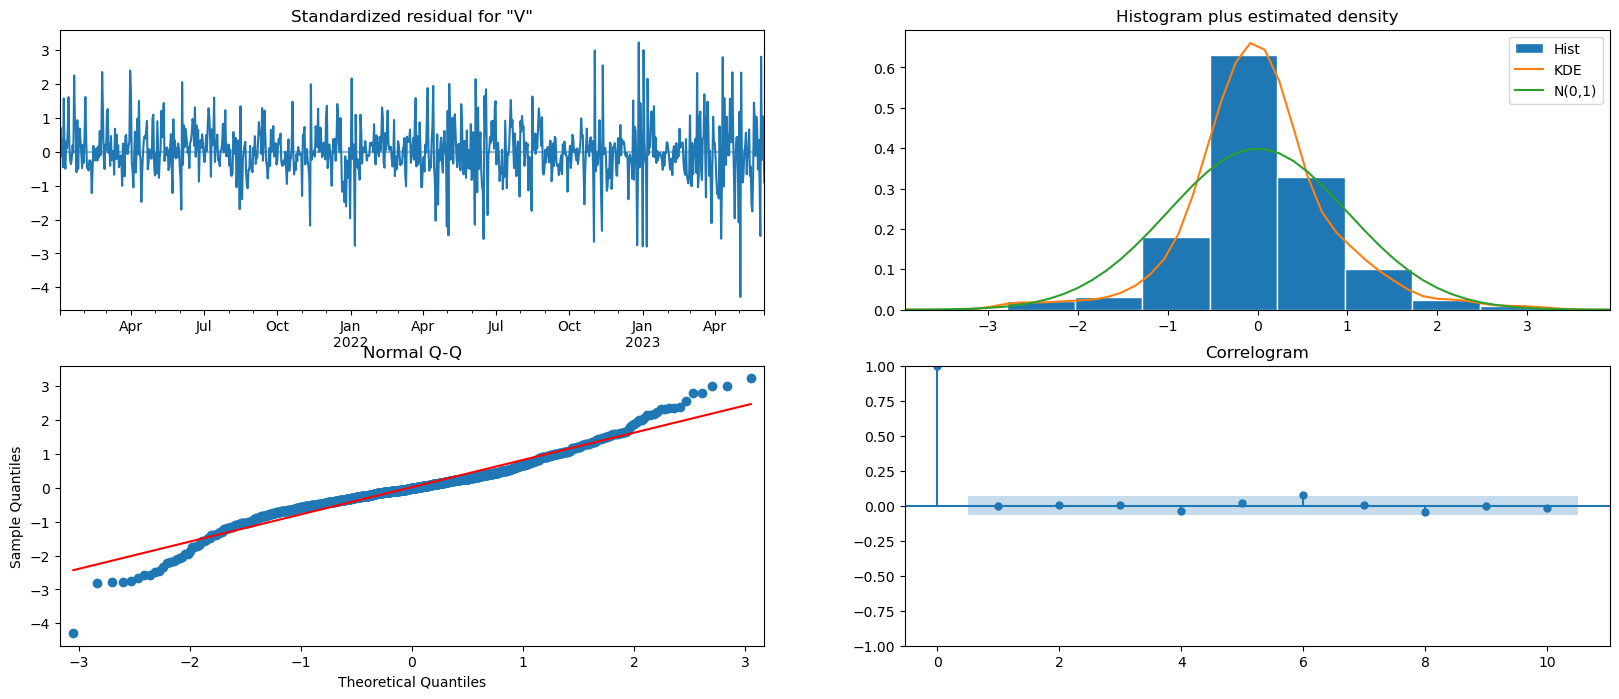

In [292]:
arima.plot_diagnostics(figsize=(20, 8))
plt.show()

## Prophet model

In [293]:
ds = pd.to_datetime(df.index)
df_prophet = pd.DataFrame({"ds": ds, "y": df.Volume})
df_prophet.reset_index(drop=True, inplace=True)
df_prophet.head()

,ds,y
0,2021-01-01,11366.0
1,2021-01-02,106466.0
2,2021-01-03,298551.0
3,2021-01-04,167549.0
4,2021-01-05,237147.0


In [294]:
test_days = 90
train = df_prophet[:-test_days]
test = df_prophet[-test_days:]

len(train), len(test)

(883, 90)

In [295]:
model = Prophet(seasonality_mode='additive')
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.fit(train)

22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing


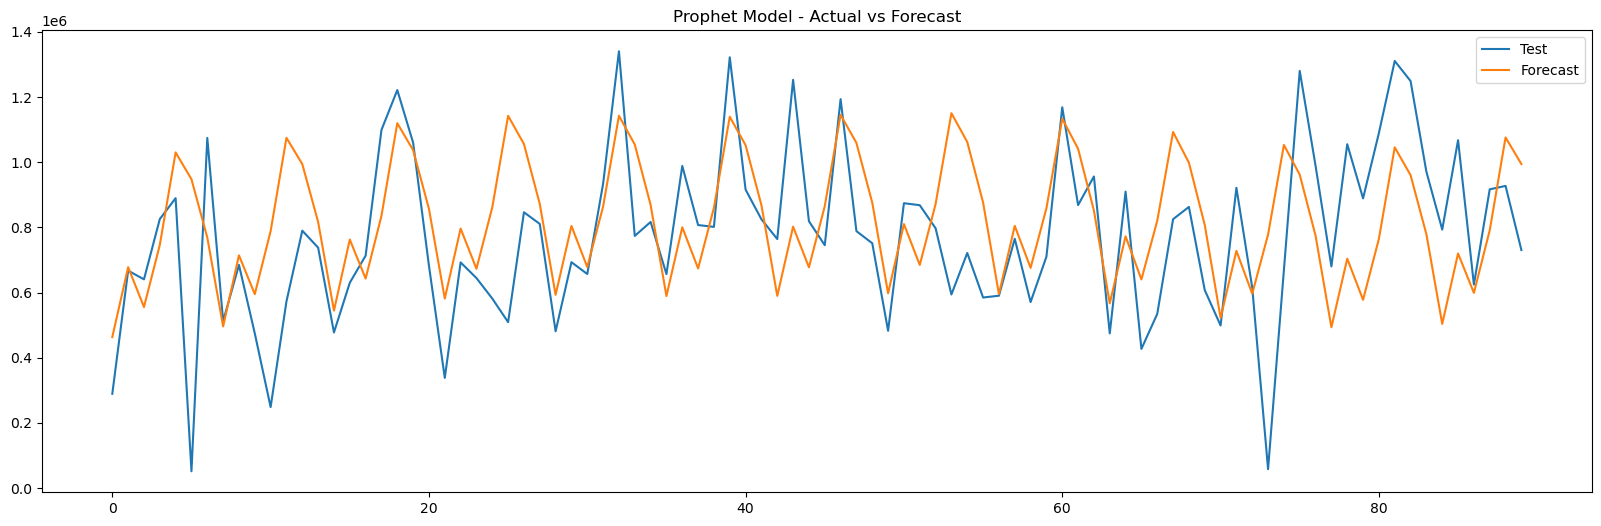

RMSE: 248831.5707
MAE: 190225.8196


In [296]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_true, label='Test')
plt.plot(y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('Prophet Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")

## Machine Learning / Deep Learning forecasting models

In [297]:
df.isna().sum().sum(), df.duplicated().sum()

(0, 0)

## Feature engineering

In [298]:
for i in df.columns:
    print(i, df[i].nunique())

Volume 972
dateYear 3
dateMonth 12
dateDay 31
dateDayOfYear 365
dateWeekOfMonth 6
dateQuarter 4
dateIsWeekend 2
dateIsHolidayInd 2
dateWeekDayStartsMonday 7
dateWeekOfYearStartsMonday 53
firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday 2
isThuHolyday 2
isFriHolyday 2
isSatHolyday 2
isWeekendParcelServiceBreakInd 2
firstDayWorkBefore_year 4
firstDayWorkBefore_month 12
firstDayWorkBefore_day 31
firstDayWorkAfter_year 3
firstDayWorkAfter_month 12
firstDayWorkAfter_day 31
firstDayNoHolidayNoSaturdayAfter_year 3
firstDayNoHolidayNoSaturdayAfter_month 12
firstDayNoHolidayNoSaturdayAfter_day 31
firstDayNoHolidayNoSundayAfter_year 3
firstDayNoHolidayNoSundayAfter_month 12
firstDayNoHolidayNoSundayAfter_day 31
firstDayNoSaturdayNoHolidayOrSundayHoliday_year 4
firstDayNoSaturdayNoHolidayOrSundayHoliday_month 12
firstDayNoSaturdayNoHolidayOrSundayHoliday_day 31
courierBillingPeriodStartDateFk_year 3
courierBillingPeriodStartDateFk_month 12
courierBillingPeriodStartDateFk_day 2
courierBillingPe

In [299]:
cyclic_features = ["dateMonth", "dateDayOfYear", "dateWeekOfMonth", "dateQuarter", "dateWeekDayStartsMonday", "dateWeekOfYearStartsMonday"]

def create_cyclic_features(df, column, period):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / period)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / period)
    df = df.drop(column, axis=1)
    return df

for col in cyclic_features:
    df = create_cyclic_features(df, col, df[col].nunique())


df.head()

,Volume,dateYear,dateDay,dateIsWeekend,dateIsHolidayInd,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,...,dateDayOfYear_sin,dateDayOfYear_cos,dateWeekOfMonth_sin,dateWeekOfMonth_cos,dateQuarter_sin,dateQuarter_cos,dateWeekDayStartsMonday_sin,dateWeekDayStartsMonday_cos,dateWeekOfYearStartsMonday_sin,dateWeekOfYearStartsMonday_cos
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,11366.0,2021,1,0,1,0,1,1,0,0,...,0.017213,0.999852,0.866025,0.5,1.0,6.123234e-17,-9.749279e-01,-0.222521,0.118273,0.992981
2021-01-02,106466.0,2021,2,1,0,0,1,1,0,1,...,0.034422,0.999407,0.866025,0.5,1.0,6.123234e-17,-7.818315e-01,0.623490,0.118273,0.992981
2021-01-03,298551.0,2021,3,1,0,0,0,0,0,0,...,0.051620,0.998667,0.866025,-0.5,1.0,6.123234e-17,-2.449294e-16,1.000000,0.118273,0.992981
2021-01-04,167549.0,2021,4,0,0,0,0,0,0,0,...,0.068802,0.997630,0.866025,-0.5,1.0,6.123234e-17,7.818315e-01,0.623490,0.234886,0.972023
2021-01-05,237147.0,2021,5,0,0,0,0,0,0,0,...,0.085965,0.996298,0.866025,-0.5,1.0,6.123234e-17,9.749279e-01,-0.222521,0.234886,0.972023


In [318]:
X = df.drop("Volume", axis=1)
y = df["Volume"]

test_days = 90
X_train, X_test = X[:-test_days], X[-test_days:]
y_train, y_test = y[:-test_days], y[-test_days:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (883, 49)
y_train shape: (883,)
X_test shape: (90, 49)
y_test shape: (90,)


In [319]:
X_train.columns

Index(['dateYear', 'dateDay', 'dateIsWeekend', 'dateIsHolidayInd',
       'firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday', 'isThuHolyday',
       'isFriHolyday', 'isSatHolyday', 'isWeekendParcelServiceBreakInd',
       'firstDayWorkBefore_year', 'firstDayWorkBefore_month',
       'firstDayWorkBefore_day', 'firstDayWorkAfter_year',
       'firstDayWorkAfter_month', 'firstDayWorkAfter_day',
       'firstDayNoHolidayNoSaturdayAfter_year',
       'firstDayNoHolidayNoSaturdayAfter_month',
       'firstDayNoHolidayNoSaturdayAfter_day',
       'firstDayNoHolidayNoSundayAfter_year',
       'firstDayNoHolidayNoSundayAfter_month',
       'firstDayNoHolidayNoSundayAfter_day',
       'firstDayNoSaturdayNoHolidayOrSundayHoliday_year',
       'firstDayNoSaturdayNoHolidayOrSundayHoliday_month',
       'firstDayNoSaturdayNoHolidayOrSundayHoliday_day',
       'courierBillingPeriodStartDateFk_year',
       'courierBillingPeriodStartDateFk_month',
       'courierBillingPeriodStartDateFk_day',
     

In [320]:
scaler = MinMaxScaler()

num_columns = ['dateYear', 'dateDay', 'firstDayWorkBefore_year', 'firstDayWorkBefore_month',
               'firstDayWorkBefore_day', 'firstDayWorkAfter_year',
               'firstDayWorkAfter_month', 'firstDayWorkAfter_day',
               'firstDayNoHolidayNoSaturdayAfter_year',
               'firstDayNoHolidayNoSaturdayAfter_month',
               'firstDayNoHolidayNoSaturdayAfter_day',
               'firstDayNoHolidayNoSundayAfter_year',
               'firstDayNoHolidayNoSundayAfter_month',
               'firstDayNoHolidayNoSundayAfter_day',
               'firstDayNoSaturdayNoHolidayOrSundayHoliday_year',
               'firstDayNoSaturdayNoHolidayOrSundayHoliday_month',
               'firstDayNoSaturdayNoHolidayOrSundayHoliday_day',
               'courierBillingPeriodStartDateFk_year',
               'courierBillingPeriodStartDateFk_month',
               'courierBillingPeriodStartDateFk_day',
               'courierBillingPeriodEndDateFk_year',
               'courierBillingPeriodEndDateFk_month',
               'courierBillingPeriodEndDateFk_day',
               'Orders', 'temp_max', 'temp_min', 'temp_avg',
               'total_rainfall', 'snow_cover']



X_train = X_train.copy()
X_test = X_test.copy()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

## Decision Trees and Ensembles models

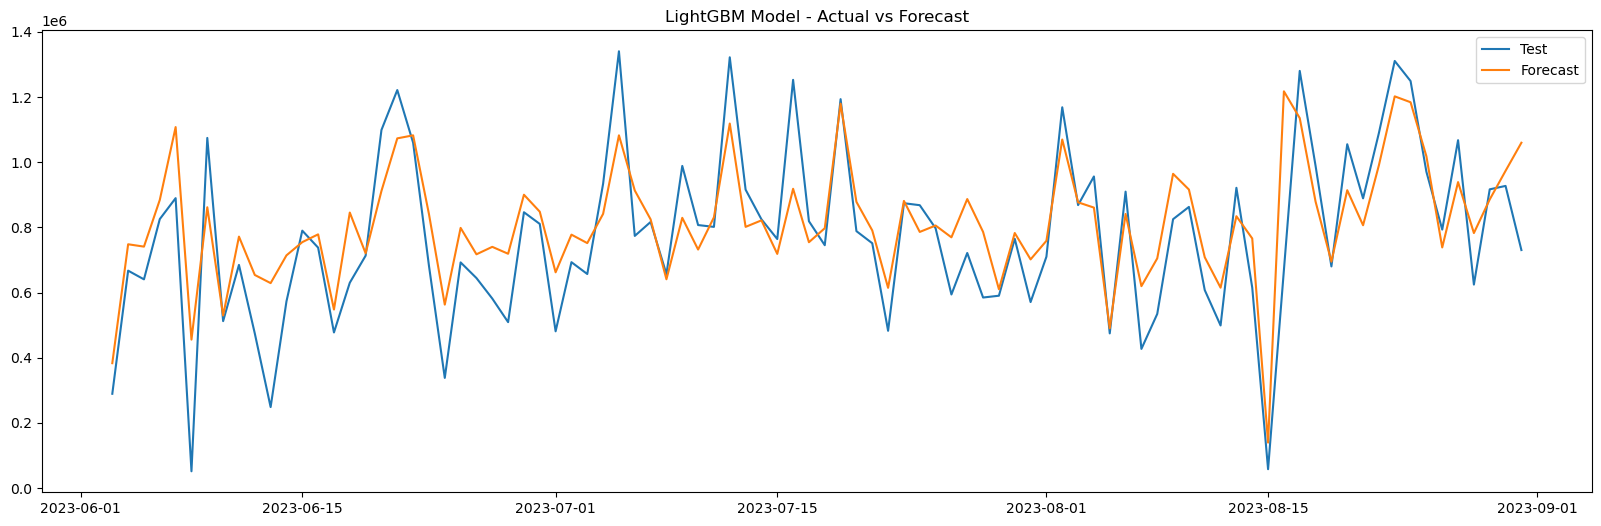

RMSE: 148680.0810
MAE: 114454.6396


In [328]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',  
    'metric': 'rmse',         
    'boosting_type': 'gbdt',
    'verbose': -1 
}

lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
)

y_pred = lgb.predict(X_test, num_iteration=lgb.best_iteration)

mae_lgb = mean_absolute_error(y_test, y_pred)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('LightGBM Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_lgb:.4f}")
print(f"MAE: {mae_lgb:.4f}")

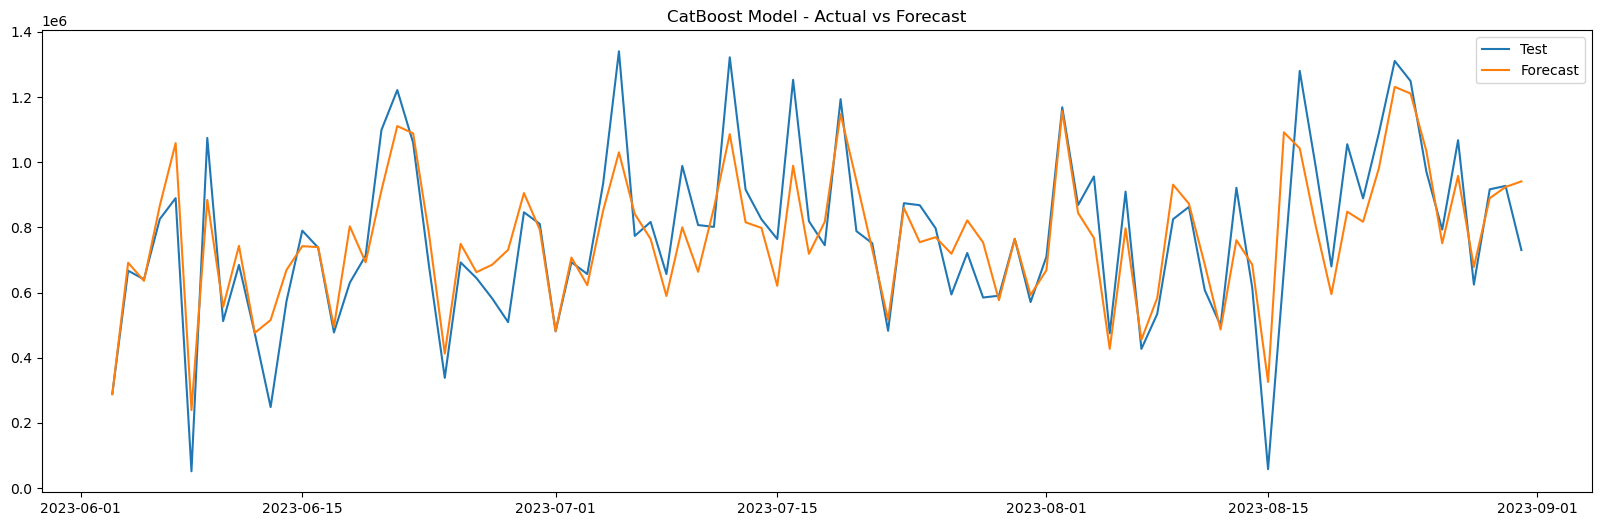

RMSE: 123858.9865
MAE: 91915.4546


In [332]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    logging_level='Silent', 
)

cat.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        use_best_model=True,
        logging_level='Silent')

y_pred = cat.predict(X_test)

mae_cat = mean_absolute_error(y_test, y_pred)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('CatBoost Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_cat:.4f}")
print(f"MAE: {mae_cat:.4f}")

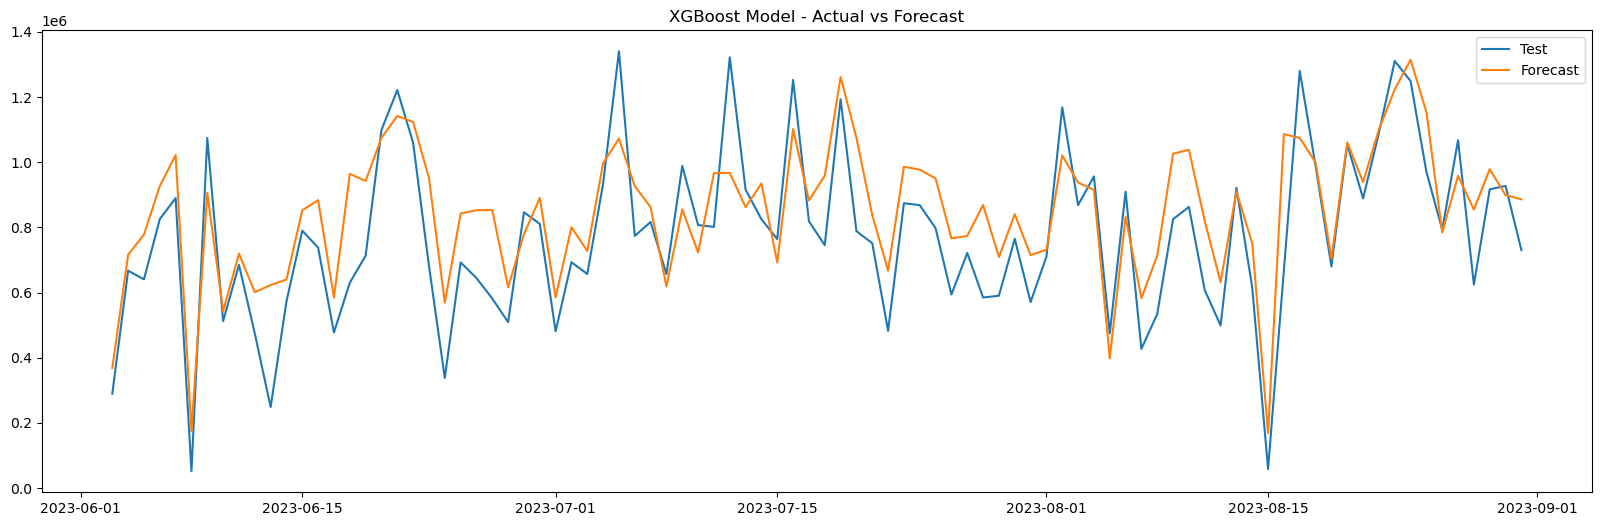

RMSE: 153206.2630
MAE: 126152.9854


In [303]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('XGBoost Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

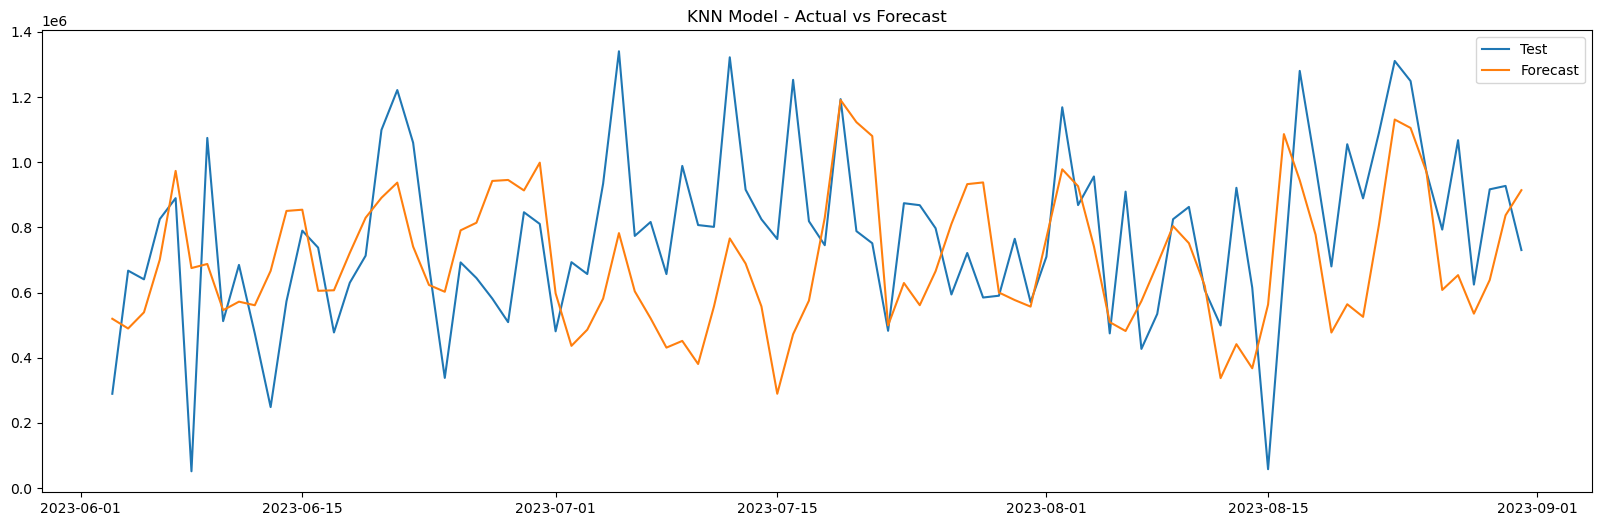

RMSE: 279350.3378
MAE: 229828.9267


In [304]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('KNN Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_knn:.4f}")
print(f"MAE: {mae_knn:.4f}")

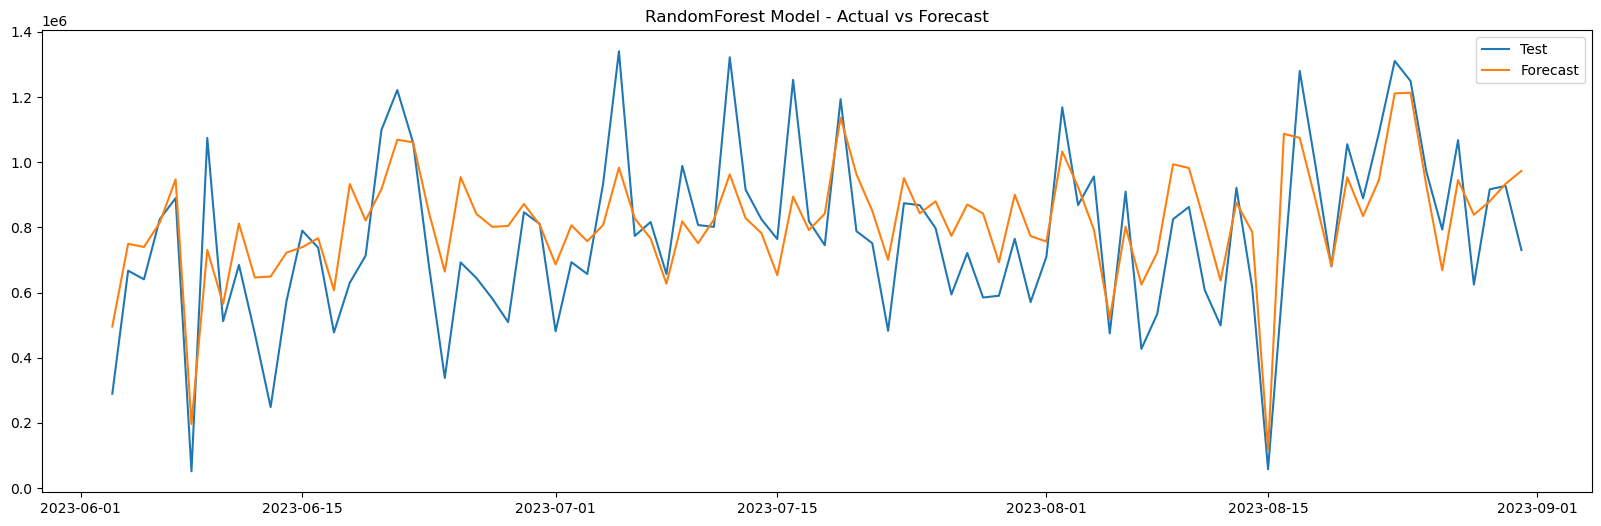

RMSE: 167038.0820
MAE: 135847.3636


In [305]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('RandomForest Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

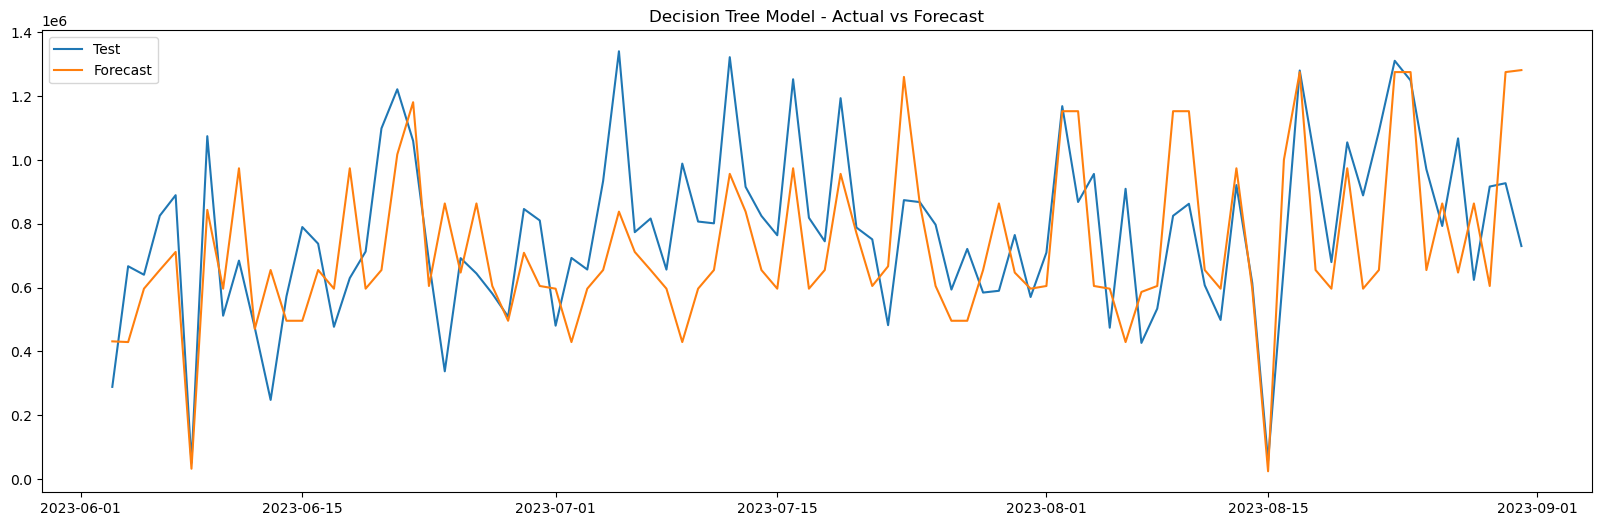

RMSE: 236236.4176
MAE: 188383.2111


In [306]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

mae_tree = mean_absolute_error(y_test, y_pred)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('Decision Tree Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_tree:.4f}")
print(f"MAE: {mae_tree:.4f}")

## LSTM model

In [307]:
time_steps = 10

y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = scaler.transform(y_test.to_numpy().reshape(-1, 1))

def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target.iloc[i] if isinstance(target, pd.Series) else target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train, time_steps)
X_test, y_test = create_sequences(X_test, y_test, time_steps)

y_train = y_train.squeeze()
y_test = y_test.squeeze()  

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape) 

X_train shape: (873, 10, 49)
y_train shape: (873,)
X_test shape: (80, 10, 49)
y_test shape: (80,)


In [308]:
lstm = Sequential()
lstm.add(InputLayer((X_train.shape[1], X_train.shape[2])))

lstm.add(LSTM(units=100, return_sequences=True))
lstm.add(Dropout(0.5))
lstm.add(LSTM(units=100, return_sequences=False))
lstm.add(Dropout(0.5))
lstm.add(Dense(units=1))

lstm.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,501 (548.83 KB)

 Trainable params: 140,501 (548.83 KB)

 Non-trainable params: 0 (0.00 B)

In [309]:
history = lstm.fit(
    X_train, y_train, 
    epochs = 200,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/200


2024-12-18 22:35:40.896115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0999 - val_loss: 0.0448
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0536 - val_loss: 0.0344
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0437 - val_loss: 0.0376
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0408 - val_loss: 0.0322
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0393 - val_loss: 0.0325
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0374 - val_loss: 0.0321
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0345 - val_loss: 0.0345
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0346 - val_loss: 0.0343
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0342 - val_loss: 0.0345
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0318 - val_loss: 0.0342
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0298 - val_loss: 0.0343
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


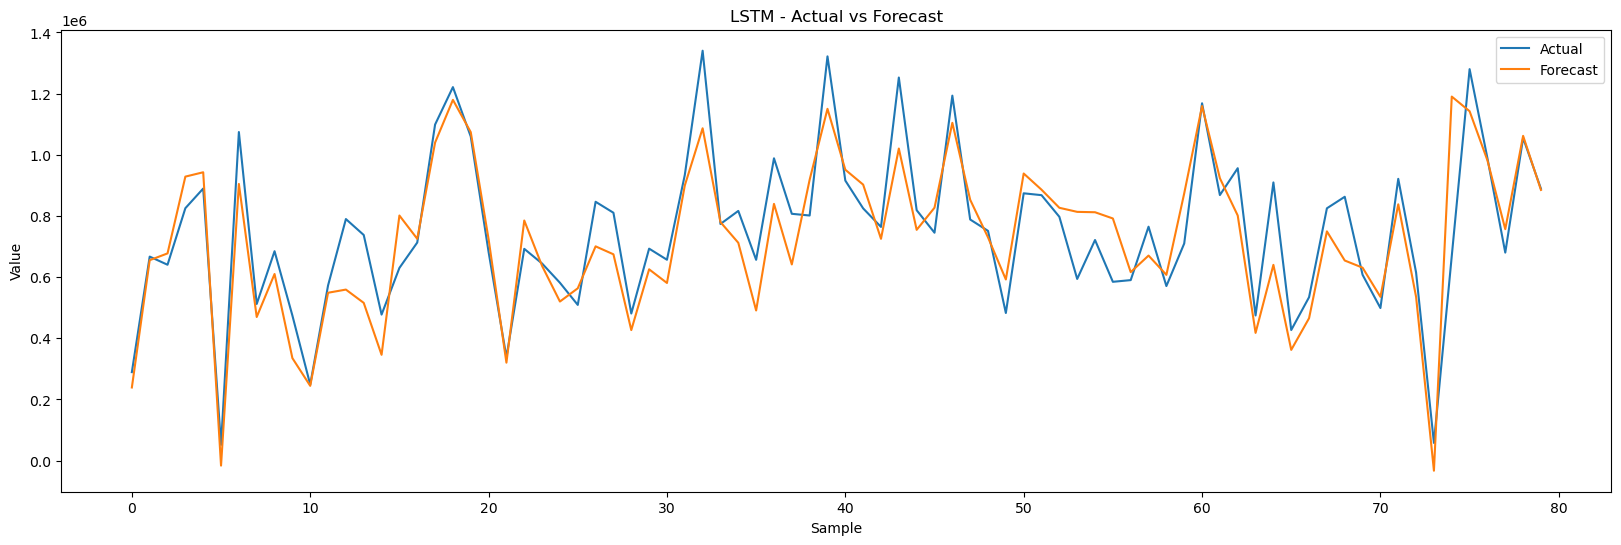

RMSE: 123604.0862
MAE: 92236.1647


In [313]:
# Predict
y_pred_scaled = lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).squeeze()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()

# Evaluation
mae_lstm = mean_absolute_error(y_test_original, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred))

# Plot
plt.figure(figsize=(20, 6))
plt.plot(range(len(y_test_original)), y_test_original, label="Actual")
plt.plot(range(len(y_test_original)), y_pred, label="Forecast")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("LSTM - Actual vs Forecast")
plt.legend(loc="best")
plt.show()

print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")

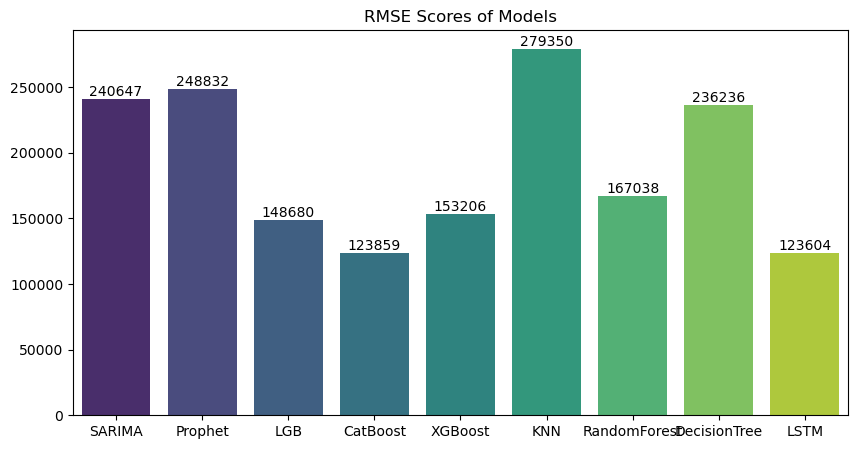

In [335]:
rmse_scores = [rmse_sarima, rmse_prophet, rmse_lgb, rmse_cat, rmse_xgb, rmse_knn, rmse_rf, rmse_tree, rmse_lstm]
models = ["SARIMA", "Prophet", "LGB", "CatBoost", "XGBoost", "KNN", "RandomForest", "DecisionTree", "LSTM"]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=rmse_scores, hue = models, palette="viridis")
for i, value in enumerate(rmse_scores):
    plt.text(i, value + 0.01, f'{value:.0f}', ha='center', va='bottom')
    
plt.title("RMSE Scores of Models")
plt.show()

## Transformer model